# Character Randomized Benchmarking for CCZ Gate
#### Yihong Zhang

## Introduction

This jupyter notebook provides a numerical simulation of character randomized benchmarking for CCZ gate. The benchmar group is local 1-qubit dihedral group $\mathcal{D}_8^{\otimes 3}$ (3-design). CCZ belongs to CNOT-dihedral group.

## Pre-setting
### 1) basic function definition

In [1]:
# -*- coding: utf-8 -*-
"""
author: YihongZhang
"""
%pylab inline
%matplotlib inline
import numpy as np
import qutip as qt
import scipy as sp
import random as Random
import heapq as hp
from functools import reduce
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, p, A, B):
    return A * (p ** x) + B

#np.set_printoptions(threshold=np.inf)  #Full display the matrix 

Populating the interactive namespace from numpy and matplotlib


### 2) generation for $n$-qubit Pauli group and local Dihedral group

In [2]:
#1-qubit Pauli group
Pauli1Q = [qt.identity(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]

# 1-qubit Dihedral group
j_rota = 8 #Dihedral group parameters
Dihedral_rota = qt.rz(- 2 * np.pi / j_rota)
Dihedral1Q = []
for i in range(j_rota):
    x = Dihedral_rota ** i
    Dihedral1Q.append(x)
    x = qt.sigmax() * x
    Dihedral1Q.append(x)

def number_convert(initial_num, notation_num, length):
    temp = []
    while True:
        quotient = initial_num // notation_num
        remainder = initial_num % notation_num
        temp = temp + [remainder]
        if quotient == 0:
            break
        initial_num = quotient
    result = np.zeros(max(length, len(temp)), int8)
    for i in range(len(temp)):
        result[- 1 - i] = temp[i]
    return result

def local_group(num_qubit, singleQubit_group):
    temp = []
    num_group = len(singleQubit_group)
    if num_qubit > 1:
        for i in range(num_group ** num_qubit):
            seq = number_convert(i, num_group, num_qubit)
            temp_gate = singleQubit_group[seq[0]]
            for j in range(num_qubit - 1):
                temp_gate = qt.tensor(temp_gate, singleQubit_group[seq[j + 1]])
            temp.append(temp_gate)
    else:
        temp = singleQubit_group
    return temp

### 3) transformation between computational basis and super-operator rep

In [3]:
def chop(expr, delta=10**-10):
    return np.ma.masked_inside(expr, -delta, delta).filled(0)

def state_to_superrep(pure_state, rep_space):
    d = pure_state.shape[0]
    density_matrix = qt.ket2dm(pure_state)
    temp = np.zeros((len(rep_space), 1))
    for i in range(len(rep_space)):
        temp[i, 0] = (rep_space[i].dag() * density_matrix).tr() / np.sqrt(d)
    return temp

def measure_to_superrep(measure_basis, rep_space):
    d = measure_basis.shape[0]
    temp = np.zeros((1, len(rep_space)))
    for i in range(len(rep_space)):
        temp[0, i] = (measure_basis.dag() * rep_space[i]).tr() / np.sqrt(d)
    return temp

def channel_to_superrep(element, rep_space):
    temp = np.zeros((len(rep_space), len(rep_space)))
    for i in range(len(rep_space)):
        for j in range(len(rep_space)):
            temp[i, j] = (rep_space[i].dag() * element * rep_space[j] * element.dag()).tr()
    return temp

def superrep_to_choi(channel_superrep):
    num_qubit = int(math.log(len(channel_superrep), 4))
    temp = 0
    Pauli = local_group(num_qubit, Pauli1Q)
    for i in range(len(Pauli)):
        for j in range(len(Pauli)):
            temp = temp + channel_superrep[i, j] * qt.tensor(Pauli[i].trans(), Pauli[j])
    return temp / (4**num_qubit)

#depolarizing channel in super-operator rep
#def dep_superrep(t, p, num_qubit, rep_space):
#    pauli_group = local_group(num_qubit, Pauli1Q)
#    temp = np.zeros((len(rep_space), len(rep_space)))
#    d = 2**num_qubit
#    for i in range(len(rep_space)):
#        for j in range(len(rep_space)):
#            temp_pauli = 0
#            for k in range(len(pauli_group)):
#                temp_pauli += (t - p)/d/d * pauli_group[k] * (rep_space[j] / np.sqrt(d)) * pauli_group[k]
#            temp_chan = p * (rep_space[j] / np.sqrt(d)) + temp_pauli
#            temp[i, j] = chop(((rep_space[i].dag() / np.sqrt(d)) * temp_chan).tr().real)
#    return temp

def dep_superrep(t, p, num_qubit):
    temp = np.zeros((4**num_qubit, 4**num_qubit))
    temp[0, 0] = t
    for i in range(4**num_qubit - 1):
        temp[i + 1, i + 1] = p
    return temp

def local_group_superrep(num_qubit, singleQubit_group):
    temp = []
    group_superrep = []
    num_group = len(singleQubit_group)
    for i in range(num_group):
        group_superrep.append(unitary_superrep(singleQubit_group[i], Pauli1Q))
    for i in range(num_group ** num_qubit):
        seq = number_convert(i, num_group, num_qubit)
        temp_gate = 1
        for j in range(num_qubit):
            temp_gate = np.kron(temp_gate, group_superrep[seq[j]])
        temp.append(temp_gate)
    return temp

def unitary_superrep(unitary, rep_space):
    d = unitary.shape[0]
    temp = np.zeros((len(rep_space), len(rep_space)))
    for i in range(len(rep_space)):
        for j in range(len(rep_space)):
            temp[i, j] = chop(((rep_space[i].dag() / np.sqrt(d)) * unitary * (rep_space[j] / np.sqrt(d)) * unitary.dag()).tr().real)
    return temp

def twirling(channel_superrep, group_superrep):
    num_qubit = int(math.log(len(group_superrep[0]), 4))
    temp = 0
    for i in range(len(group_superrep)):
        temp += np.dot(np.dot(group_superrep[i], channel_superrep), group_superrep[i].conj().T)
    temp /= len(group_superrep)
    return temp

def process_fidelity(channel_superrep):
    return np.trace(channel_superrep) / len(channel_superrep)

H3 = qt.tensor(qt.identity(2), qt.identity(2), qt.snot())
ccz = H3 * qt.toffoli() * H3

## Error model definition and some basic process function definition

In [4]:
num_qubit = 3
Pauli3Q = local_group(num_qubit, Pauli1Q)
Dihedral3Q = local_group(num_qubit, Dihedral1Q)

### 1) error channel for local Dihedral group

A noisy 1-qubit gate can be described by
\begin{equation}
\tilde{\mathcal{G}} = \mathcal{G} \circ \Lambda_{Rz} \circ \Lambda_{1dep},
\end{equation}
where
\begin{equation}
\begin{split}
&\Lambda_{Rz} = Rz(\theta), \\
&\Lambda_{1dep}(\rho) = p_1\rho + (t_1-p_1)\frac{I}{d_1}, d_1 = 2.
\end{split}
\end{equation}

In [5]:
[theta1, theta2, theta3] = [0.01, 0.02, 0.03]
[t1, t2, t3] = [1, 1, 1]
[p1, p2, p3] = [0.998, 0.997, 0.996]
[depQ1, depQ2, depQ3] = [dep_superrep(t1, p1, 1), dep_superrep(t2, p2, 1), dep_superrep(t3, p3, 1)]
[PhaseErrQ1, PhaseErrQ2, PhaseErrQ3] = [unitary_superrep(qt.rz(theta1), Pauli1Q), unitary_superrep(qt.rz(theta2), Pauli1Q), unitary_superrep(qt.rz(theta3), Pauli1Q)]
[chQ1, chQ2, chQ3] =  [np.dot(PhaseErrQ1, depQ1), np.dot(PhaseErrQ2, depQ2), np.dot(PhaseErrQ3, depQ3)]
SingleQubit_channel = np.kron(np.kron(chQ1, chQ2), chQ3)
print('The theoretic process fidelity for the gate of local Dihedral group is', process_fidelity(SingleQubit_channel))

The theoretic process fidelity for the gate of local Dihedral group is 0.9929173341377812


### 2) error channel for CCZ gate
A noisy CCZ gate can by decribed by
\begin{equation}
\tilde{CCZ} = CCZ \circ \Lambda_{ccz},
\end{equation}
where
\begin{equation}
\Lambda_{ccz} = \Lambda_{system} \circ \Lambda_{dep},
\end{equation}
here $\Lambda_{control}$ is the coherent error, $\Lambda_{dep}$ is the depolarizing channel. We have
\begin{equation}
\begin{split}
&\Lambda_{system} = 
\begin{bmatrix}
1 & & & & & & & \\
 & 1 & & & & & & \\
 & & 1 & & & & & \\
 & & & \cos(a_1)e^{-ib_1} & & & & \\
 & & & & 1 & & & \\
 & & & & & \cos(a_2)e^{-ib_2} & & \\
 & & & & & & \cos(a_3)e^{-ib_3} & \\
 & & & & & & & \cos(a_4)3^{-ib_4} 
\end{bmatrix}
\circ \Lambda_1 \circ \Lambda_2 \circ \Lambda_3, \\
&\Lambda_1 = \mathrm{expm}(ic_1 \mathrm{SWAP}_{23}), 
\Lambda_2 = \mathrm{expm}(ic_2 \mathrm{SWAP}_{13}),
\Lambda_3 = \mathrm{expm}(ic_3 \mathrm{SWAP}_{12}); \\
&\Lambda_{dep}(\rho) = p\rho + (t-p)\frac{I}{d}, d = 2^3.
\end{split}
\end{equation}

In [6]:
#parameters setting
[a1, a2, a3, a4] = [0.11, 0.12, 0.13, 0.14]
[b1, b2, b3, b4] = [0.14, 0.13, 0.12, np.pi - 0.11]
[c1, c2, c3] = [0.1, 0.12, 0.13]

#channel generation
channel_control = ccz * qt.Qobj(np.array([[1, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0], \
                                    [0, 0, 0, cos(a1)*exp(-1j * b1), 0, 0, 0, 0], [0, 0, 0, 0, 1, 0, 0, 0], \
                                    [0, 0, 0, 0, 0, cos(a2)*exp(-1j * b2), 0, 0], [0, 0, 0, 0, 0, 0, cos(a3)*exp(-1j * b3), 0], \
                                   [0, 0, 0, 0, 0, 0, 0, cos(a4)*exp(-1j * b4)]]), dims=[[2, 2, 2], [2, 2, 2]])
swap23 = qt.tensor(qt.identity(2), qt.swap())
swap12 = qt.tensor(qt.swap(), qt.identity(2))
swap13 = swap12 * swap23 * swap12
channel_swap23 = (1j * c1 * swap23).expm()
channel_swap12 = (1j * c3 * swap12).expm()
channel_swap13 = (1j * c2 * swap13).expm()
channel_system = channel_control * channel_swap23 * channel_swap12 * channel_swap13
channel_system_superrep = unitary_superrep(channel_system, Pauli3Q)
[t_3Q, p_3Q] = [1, 0.93]
dep_3Q = dep_superrep(t_3Q, p_3Q, num_qubit)
ThreeQubit_channel = np.dot(channel_system_superrep, dep_3Q)
print('The theoretic process fidelity for the CCZ gate is', process_fidelity(ThreeQubit_channel))

The theoretic process fidelity for the CCZ gate is 0.8801087789673829


### 3) SPAM settings

In [7]:
[X_state0, X_state1] = [(qt.ket("0") + qt.ket("1")).unit(), (qt.ket("0") - qt.ket("1")).unit()]
[Y_state0, Y_state1] = [(qt.ket("0") + 1j * qt.ket("1")).unit(), (qt.ket("0") - 1j * qt.ket("1")).unit()]
[Z_state0, Z_state1] = [qt.ket("0"), qt.ket("1")]

class SPAM_setting:
    
    def __init__(self, basis_setting):
        self.setting = basis_setting
        self.num = len(basis_setting)
        self.initial_state = np.zeros(4**self.num)
        self.measure_observable = np.zeros(4**self.num)
        self.measure_basis = []
        self.Allmeasure_basis_result = []
    
    def add_initial_state(self):
        temp = 1
        for i in range(self.num):
            if self.setting[i] == 'I':
                temp = np.kron(temp, state_to_superrep(Z_state0, Pauli1Q))
            elif self.setting[i] == 'X':
                temp = np.kron(temp, state_to_superrep(X_state0, Pauli1Q))
            elif self.setting[i] == 'Y':
                temp = np.kron(temp, state_to_superrep(Y_state0, Pauli1Q))
            elif self.setting[i] == 'Z':
                temp = np.kron(temp, state_to_superrep(Z_state0, Pauli1Q))
            else:
                print('The input format is wrong.')
        self.initial_state = temp
    
    def add_measure_observable(self):
        temp = 1
        for i in range(self.num):
            if self.setting[i] == 'I':
                temp = np.kron(temp, measure_to_superrep(qt.identity(2), Pauli1Q))
            elif self.setting[i] == 'X':
                temp = np.kron(temp, measure_to_superrep(qt.sigmax(), Pauli1Q))
            elif self.setting[i] == 'Y':
                temp = np.kron(temp, measure_to_superrep(qt.sigmay(), Pauli1Q))
            elif self.setting[i] == 'Z':
                temp = np.kron(temp, measure_to_superrep(qt.sigmaz(), Pauli1Q))
            else:
                print('The input format is wrong.')
        self.measure_observable = temp
    
    def add_measure_basis(self):
        temp_setting = []
        order = np.zeros(self.num)
        for i in range(self.num):
            if self.setting[i] == 'X':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(X_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(X_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Y':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Y_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Y_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Z':
                order[i] = 1
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Z_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Z_state1), Pauli1Q), -1]])
        for j in range(2**int(sum(order))):
            temp_state = 1
            temp_measure_result = 1
            temp_order = 0
            seq = number_convert(j, 2, int(sum(order)))
            for k in range(self.num):
                if order[k] == 1:
                    temp_state = np.kron(temp_state, temp_setting[temp_order][seq[temp_order]][0])
                    temp_measure_result *= temp_setting[temp_order][seq[temp_order]][1]
                    temp_order += 1
                else:
                    temp_state = np.kron(temp_state, measure_to_superrep(qt.identity(2), Pauli1Q))
            self.measure_basis.append([temp_state, temp_measure_result])
            
    def measure_basis_result(self):
        temp_setting = []
        for i in range(self.num):
            if self.setting[i] == 'X':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(X_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(X_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Y':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Y_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Y_state1), Pauli1Q), -1]])
            elif self.setting[i] == 'Z':
                temp_setting.append([[measure_to_superrep(qt.ket2dm(Z_state0), Pauli1Q), 1], [measure_to_superrep(qt.ket2dm(Z_state1), Pauli1Q), -1]])
            else:
                print('The measurement basis is not complete.')
        for j in range(2**self.num):
            temp_state = 1
            temp_measure_result = []
            seq = number_convert(j, 2, self.num)
            for k in range(self.num):
                temp_state = np.kron(temp_state, temp_setting[k][seq[k]][0])
                temp_measure_result.append(temp_setting[k][seq[k]][1])
            self.Allmeasure_basis_result.append([temp_state, temp_measure_result])

### 4) Quantum process function

In [8]:
# generation of local Dihedral group
Dihedral3Q_superrep = local_group_superrep(num_qubit, Dihedral1Q)
group_num = len(Dihedral3Q)
experiment_num_ref = 200
sequence_length_ref = 50
twirling_group = Dihedral3Q_superrep
group_channel = SingleQubit_channel
int_gate = unitary_superrep(ccz, Pauli3Q)
int_gate_channel = ThreeQubit_channel

In [9]:
class RB_process:
    
    def __init__(self, seq_length):
        self.seq_length = seq_length
        self.process_ref = []
        self.process_int = []
    
    def compute_process_ref(self):
        num_group = len(twirling_group)
        sample_noisy_process = 1
        sample_ideal_process = 1
        for i in range(self.seq_length + 1):
            sample_num = Random.randrange(0, num_group)
            sample_noisy_process = np.dot(np.dot(group_channel, twirling_group[sample_num]), sample_noisy_process)
            sample_ideal_process = np.dot(twirling_group[sample_num], sample_ideal_process)
        self.process_ref.append([sample_noisy_process, sample_ideal_process])

#    def compute_process_ref(self):
#        num_group = len(twirling_group)
#        gate_order = np.random.randint(0, num_group, size = self.seq_length + 1)
#        gate_sequence_ideal = [twirling_group[i] for i in gate_order[::-1]]
#        gate_sequence_noisy0 = np.dot(group_channel, gate_sequence_ideal)
#        gate_sequence_noisy = [gate_sequence_noisy0[:,i,:] for i in range(self.seq_length + 1)]
#        sample_noisy_process = reduce(np.dot, gate_sequence_noisy)
#        sample_ideal_process = reduce(np.dot, gate_sequence_ideal)
#        self.process_ref.append([sample_noisy_process, sample_ideal_process])
        
    def compute_process_int(self):
        num_group = len(twirling_group)
        sample_num0 = Random.randrange(0, num_group)
        sample_noisy_process = twirling_group[sample_num0]
        sample_ideal_process0 = sample_noisy_process
        sample_ideal_process = 1
        for i in range(self.seq_length):
            sample_num = Random.randrange(0, num_group)
            sample_noisy_process = np.dot(np.dot(group_channel, twirling_group[sample_num]), sample_noisy_process)
            sample_noisy_process = np.dot(np.dot(int_gate_channel, int_gate), sample_noisy_process)
            sample_ideal_process = np.dot(int_gate, np.dot(twirling_group[sample_num], sample_ideal_process))
        sample_noisy_process = np.dot(sample_ideal_process.T.conj(), sample_noisy_process)
        self.process_int.append([sample_noisy_process, sample_ideal_process0])

### 5) Measurement function

In [10]:
class RB_measure:
    
    def __init__(self, quantum_process, basis_setting):
        self.process = quantum_process
        self.basis = SPAM_setting(basis_setting)
        self.basis.add_initial_state()
        self.survival_probability = -2
        self.singleshot_measure = -2
        self.sample_singleshot_measure = []
        self.sample_measure_result = []
    
    def compute_survival_probability(self, character_order):
        self.basis.add_measure_observable()
        state = self.basis.initial_state
        observable = self.basis.measure_observable
        prob = np.dot(observable, np.dot(self.process[0][0], state))
        character_gate = self.process[0][1]
        self.survival_probability = 2 * (character_gate[61, 61] + character_gate[62, 62]) * prob[0][0]
    
    def compute_singleshot_measure(self, character_order):
        self.basis.add_measure_basis()
        state = self.basis.initial_state
        measure_basis = self.basis.measure_basis
        num_basis = len(measure_basis)
        prob_basis = [0, 0, 0]
        temp_prob = 0
        for i in range(num_basis):
            temp_prob = np.dot(measure_basis[i][0], np.dot(self.process[0][0], state))[0][0]
            if temp_prob >= 0:
                if measure_basis[i][1] == 1:
                    prob_basis[0] += temp_prob
                elif measure_basis[i][1] == -1:
                    prob_basis[1] += temp_prob
                else:
                    print('Measurement basis is wrong')
            else:
                print('Probability for measurement basis is wrong')
        prob_basis[2] = 1 - sum(prob_basis)
        character_gate = self.process[0][1]
        self.singleshot_measure = 1 * (character_gate[12, 12]) * np.random.choice([1, -1, 0], p = chop(prob_basis))

    def collect_singleshot_measure(self, character_order):
        self.basis.add_measure_basis()
        state = self.basis.initial_state
        measure_basis = self.basis.measure_basis
        num_basis = len(measure_basis)
        prob_basis = [0, 0, 0]
        temp_prob = 0
        for i in range(num_basis):
            temp_prob = np.dot(measure_basis[i][0], np.dot(self.process[0][0], state))[0][0]
            if temp_prob >= 0:
                if measure_basis[i][1] == 1:
                    prob_basis[0] += temp_prob
                elif measure_basis[i][1] == -1:
                    prob_basis[1] += temp_prob
                else:
                    print('Measurement basis is wrong')
            else:
                print('Probability for measurement basis is wrong')
        prob_basis[2] = 1 - sum(prob_basis)
        d_character = len(character_order)
        temp_weight = 0
        for r in range(d_character):
                temp_weight += self.process[0][1][character_order[r], character_order[r]]
        temp_measure = np.random.choice([1, -1, 0], p = chop(prob_basis))
        self.sample_singleshot_measure = d_character * temp_weight * temp_measure
    
    def collect_measure(self):
        self.basis.measure_basis_result()
        state = self.basis.initial_state
        measure_basis = self.basis.Allmeasure_basis_result
        num_basis = len(measure_basis)
        prob_basis = np.zeros(num_basis + 1)
        for i in range(num_basis):
            temp_prob = np.dot(measure_basis[i][0], np.dot(self.process[0][0], state))[0][0]
            if temp_prob >= 0:
                prob_basis[i] = temp_prob
            else:
                print('Probability for measurement basis is wrong')
        prob_basis[num_basis] = 1 - sum(prob_basis)
        character_gate = self.process[0][1]
        sample_order = np.random.choice(range(num_basis + 1), p = chop(prob_basis))
        if sample_order < num_basis:
            self.sample_measure_result = [measure_basis[sample_order][1], character_gate]
        else:
            self.sample_measure_result = [[0, 0, 0], character_gate]

### 6) Experiment simulation

In [11]:
class RB_experiment:
    
    def __init__(self, num_experiment, seq_length, basis_setting):
        self.num_experiment = num_experiment
        self.seq_length = seq_length
        self.basis_setting = basis_setting
        self.average_prob_ref = -2
        self.prob_var_ref = -1
        self.average_prob_int = -2
        self.prob_var_int = -1
        self.average_measure_ref = -2
        self.measure_var_ref = -1
        self.measure_ref = []
        self.average_measure_int = -2
        self.measure_var_int = -1
        self.measure_int = []
        self.collect_ref = []
        self.collect_int = []
    
    def ave_prob_ref(self, character_order):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_ref()
            measure = RB_measure(process.process_ref, self.basis_setting)
            measure.compute_survival_probability(character_order)
            temp.append(measure.survival_probability)
        self.average_prob_ref = np.mean(temp)
        self.prob_var_ref = np.var(temp)
    
    def ave_prob_int(self, character_order):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_int()
            measure =  RB_measure(process.process_int, self.basis_setting)
            measure.compute_survival_probability(character_order)
            temp.append(measure.survival_probability)
        self.average_prob_int = np.mean(temp)
        self.prob_var_int = np.var(temp)
    
    def ave_measure_ref(self, character_order):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_ref()
            measure =  RB_measure(process.process_ref, self.basis_setting)
            measure.compute_singleshot_measure(character_order)
            temp.append(measure.singleshot_measure)
        self.average_measure_ref = np.mean(temp)
        self.measure_var_ref = np.var(temp)
    
    def sample_measure_ref(self, character_order):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_ref()
            measure =  RB_measure(process.process_ref, self.basis_setting)
            measure.collect_singleshot_measure(character_order)
            temp.append(measure.sample_singleshot_measure)
        self.measure_ref = temp

    def sample_measure_int(self, character_order):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_int()
            measure =  RB_measure(process.process_int, self.basis_setting)
            measure.collect_singleshot_measure(character_order)
            temp.append(measure.sample_singleshot_measure)
        self.measure_int = temp
    
    def collect_measure_ref(self):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_ref()
            measure =  RB_measure(process.process_ref, self.basis_setting)
            measure.collect_measure()
            temp.append(measure.sample_measure_result)
        self.collect_ref = temp
        
    def collect_measure_int(self):
        temp = []
        for i in range(self.num_experiment):
            process = RB_process(self.seq_length)
            process.compute_process_int()
            measure =  RB_measure(process.process_int, self.basis_setting)
            measure.collect_measure()
            temp.append(measure.sample_measure_result)
        self.collect_int = temp

In [12]:
experiment_ZXZ = RB_experiment(100, 30, 'ZXZ')
character_order_ZXZ = [55, 59] 
experiment_ZXZ.sample_measure_int(character_order_ZXZ)
experiment_ZXZ.measure_int[0]

0.0

In [13]:
experiment1 = RB_experiment(100, 30, 'ZXZ')
experiment1.collect_measure_ref()
experiment1.collect_ref[50]

[[-1, -1, -1], array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.70710678,  0.70710678, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.70710678,  0.70710678, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ..., -0.70710678,
          0.70710678,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.70710678,
          0.70710678,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        , -1.        ]])]

In [14]:
experiment1.collect_measure_int()
experiment1.collect_int[59]

[[0, 0, 0], array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., -1.,  0., ..., -0.,  0.,  0.],
        [ 0.,  0., -1., ...,  0., -0.,  0.],
        ...,
        [ 0., -0.,  0., ...,  1., -0., -0.],
        [ 0.,  0., -0., ..., -0.,  1., -0.],
        [ 0.,  0.,  0., ..., -0., -0., -1.]])]

In [15]:
def RB_statistics_prob(num_prob, num_repeat, seq_length_total, basis_setting):
    ave_prob = []
    var_prob = []
    ave_ideal = []
    for l in range(seq_length_total):
        temp_prob = []
        temp_prob_var = []
        for i in range(num_repeat):
            experiment = RB_experiment(num_prob, l + 1, basis_setting)
            experiment.ave_prob_ref(3)
            temp_prob.append(experiment.average_prob_ref)
            temp_prob_var.append(experiment.prob_var_ref)
        ave_prob.append(temp_prob)
        var_prob.append(temp_prob_var)
        ave_ideal.append((twirling(SingleQubit_channel, Dihedral3Q_superrep) ** (l + 1))[61, 61])
        print(l)
    return [ave_prob, var_prob, ave_ideal]

        
def RB_statistics_measure(num_measure, num_repeat, seq_length_total, basis_setting):
    ave_measure = []
    var_measure = []
    ave_ideal = []
    for l in range(seq_length_total):
        temp_measure = []
        temp_measure_var = []
        for i in range(num_repeat):
            experiment = RB_experiment(num_measure, l + 1, basis_setting)
            experiment.ave_measure_ref(3)
            temp_measure.append(experiment.average_measure_ref)
            temp_measure_var.append(experiment.measure_var_ref)
        ave_measure.append(temp_measure)
        var_measure.append(temp_measure_var)
        ave_ideal.append((twirling(SingleQubit_channel, Dihedral3Q_superrep) ** (l + 1))[12, 12])
#        print(l)
    return [ave_measure, var_measure, ave_ideal]

def RB_sample_measure_ref(num_measure, seq_length_total, basis_setting, character_order, interval):
    sample_measure = []
    for l in range(0, seq_length_total, interval):
        experiment = RB_experiment(num_measure, l + 1, basis_setting)
        experiment.sample_measure_ref(character_order)
        sample_measure.append(experiment.measure_ref)
        print(l)
    np.save('./ref/ref_' + basis_setting + '.npy', sample_measure)
    return sample_measure

def RB_sample_measure_int(num_measure, seq_length_total, basis_setting, character_order, interval):
    sample_measure = []
    for l in range(0, seq_length_total, interval):
        experiment = RB_experiment(num_measure, l + 1, basis_setting)
        experiment.sample_measure_int(character_order)
        sample_measure.append(experiment.measure_int)
        print(l)
    np.save('./int/int_' + basis_setting + '.npy', sample_measure)
    return sample_measure

def RB_collect_measure_ref(num_measure, seq_length_total, basis_setting, interval):
    collect_measure = []
    for l in range(0, seq_length_total, interval):
        experiment = RB_experiment(num_measure, l + 1, basis_setting)
        experiment.collect_measure_ref()
        collect_measure.append(experiment.collect_ref)
        np.save('./ref/ref_' + basis_setting + str(l) + '.npy', experiment.collect_ref)
        print(l)
    return collect_measure

def RB_collect_measure_int(num_measure, seq_length_total, basis_setting):
    collect_measure = []
    for l in range(seq_length_total):
        experiment = RB_experiment(num_measure, l + 1, basis_setting)
        experiment.collect_measure_int()
        collect_measure.append(experiment.collect_int)
        np.save('./int/int_' + basis_setting + str(l) + '.npy', experiment.collect_int)
        print(l)
    return collect_measure

def weighted_prob(collect_measure, measure_order, character_order):
    seq_length = len(collect_measure)
    num_sample = len(collect_measure[0])
    d_character = len(character_order)
    weight_prob = []
    for i in range(seq_length):
        temp_prob = 0
        for j in range(num_sample):
            temp_measure = 1
            for l in range(len(measure_order)):
                if measure_order[l] == 1:
                    temp_measure *= collect_measure[i][j][0][l]
            temp_weight = 0
            for r in range(d_character):
                temp_weight += collect_measure[i][j][1][character_order[r], character_order[r]]
            temp_prob += d_character * temp_weight * temp_measure
        weight_prob.append(temp_prob / num_sample)
    return weight_prob

def weighted_prob2(collect_measure):
    weight_prob = []
    for i in range(len(collect_measure)):
        temp_prob = np.mean(collect_measure[i])
        weight_prob.append(temp_prob)
    return weight_prob

def twirling_ideal(seq_length_total, character_order):
    twirling_p = twirling(SingleQubit_channel, Dihedral3Q_superrep)[character_order, character_order]
    twirling_temp = []
    for l in range(seq_length_total):
        twirling_temp.append(twirling_p ** (l + 1))
    return twirling_temp

def twirling_ideal_composite(seq_length_total, character_order):
    channel = np.dot(ThreeQubit_channel, SingleQubit_channel)
    twirling_p = twirling(channel, Dihedral3Q_superrep)[character_order, character_order]
    twirling_temp = []
    for l in range(seq_length_total):
        twirling_temp.append(twirling_p ** (l + 1))
    return twirling_temp

In [16]:
num_prob = 500
num_measure = 5000
num_repeat = 5
seq_length_total = 50
basis_setting = 'ZZX'

In [ ]:
RB_prob_ref = RB_statistics_prob(num_prob, num_repeat, seq_length_total, basis_setting)

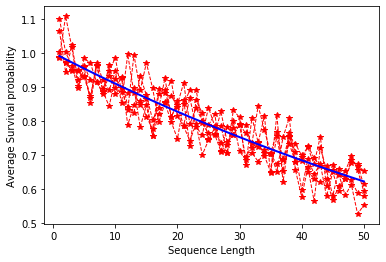

In [61]:
plt.plot(range(1, seq_length_total + 1), RB_prob_ref[0], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), RB_prob_ref[2], color="b", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Average Survival probability")
plt.show()

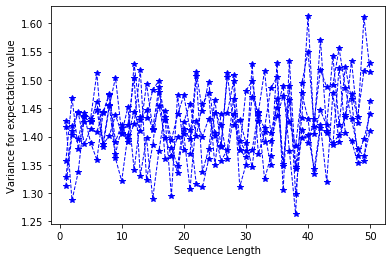

In [74]:
std_prob = np.sqrt(RB_prob_ref[1]) / RB_prob_ref[0]
plt.plot(range(1, seq_length_total + 1), std_prob, color="b", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance for expectation value")
plt.show()

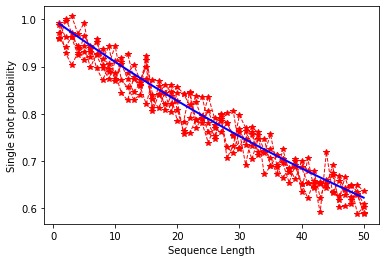

In [58]:
plt.plot(range(1, seq_length_total + 1), RB_measure_ref[0], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), RB_measure_ref[2], color="b", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Single shot probability")
plt.show()

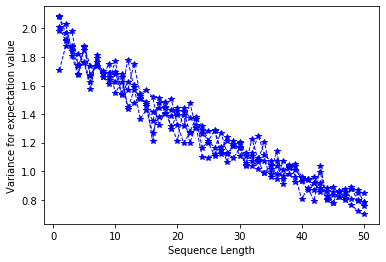

In [51]:
plt.plot(range(1, seq_length_total + 1), RB_prob_ref[1], color="b", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance for expectation value")
plt.show()

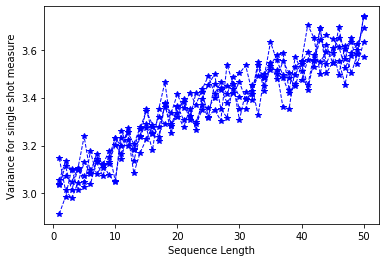

In [53]:
plt.plot(range(1, seq_length_total + 1), RB_measure_ref[1], color="b", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance for single shot measure")
plt.show()

In [16]:
RB_measure_ref0 = RB_statistics_measure(10000, 1, 50, 'ZZX')

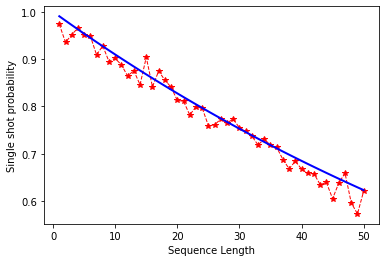

In [67]:
plt.plot(range(1, seq_length_total + 1), RB_measure_ref0[0], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), RB_measure_ref0[2], color="b", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Single shot probability")
plt.show()

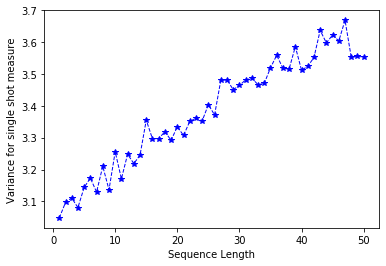

In [68]:
plt.plot(range(1, seq_length_total + 1), RB_measure_ref0[1], color="b", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance for single shot measure")
plt.show()

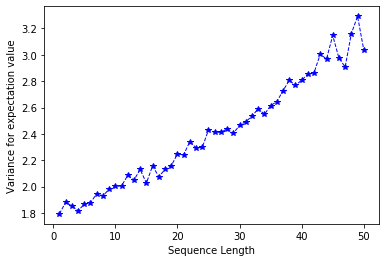

In [75]:
std_measure0 = np.sqrt(RB_measure_ref0[1]) / RB_measure_ref0[0]
plt.plot(range(1, seq_length_total + 1), std_measure0, color="b", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance for expectation value")
plt.show()

In [20]:
num_measure_total = 10000
seq_length_total = 50
basis_setting = 'ZZX'

In [21]:
sample_total = RB_measure_sample(num_measure_total, seq_length_total, basis_setting)

In [15]:
num_sample = 1000
num_repeat = 20

def sample_prob_var(num_repeat, num_sample, seq_length_total, sample_total):
    ave_total = []
    var_total = []
    for r in range(num_repeat):
        temp_ave_total = []
        temp_var_total = []
        for i in range(seq_length_total):
            order_list = [random.randint(0, len(sample_total[0][0])) for _ in range(num_sample)]
            temp_list = []
            temp_ave = []
            temp_var = []
            for j in range(num_sample):
                temp_list.append(sample_total[0][i][order_list[j]])
            temp_ave.append(np.mean(temp_list))
            temp_var.append(np.var(temp_list))
            temp_ave_total.append(temp_ave)
            temp_var_total.append(temp_var)
        ave_total.append(temp_ave_total)
        var_total.append(temp_var_total)
    return [ave_total, var_total]

In [61]:
result = sample_prob_var(num_repeat, num_sample, seq_length_total, sample_total)

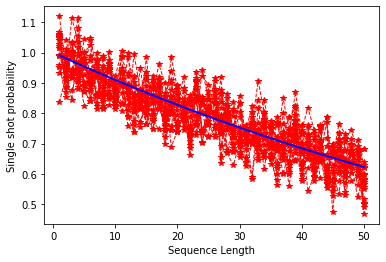

In [67]:
for i in range(num_repeat):
    plt.plot(range(1, seq_length_total + 1), result[0][i], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), sample_total[1], color="b", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Single shot probability")
plt.show()

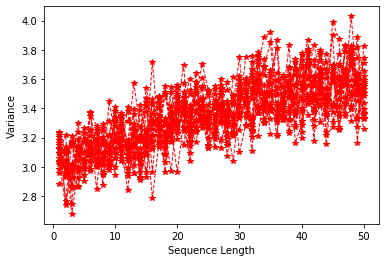

In [68]:
for i in range(num_repeat):
    plt.plot(range(1, seq_length_total + 1), result[1][i], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.xlabel("Sequence Length")
plt.ylabel("Variance")
plt.show()

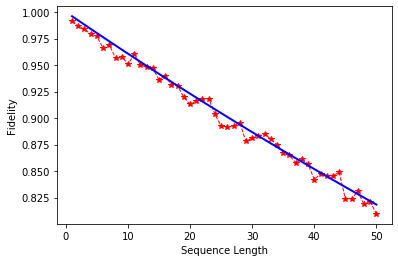

In [40]:
plt.plot(range(1, seq_length_total + 1), RB_measure_ref_IIZ[0], color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), RB_measure_ref_IIZ[2], color="b", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.show()

### Reference fidelity

(1) we can calculate $p_{IIZ}, p_{IZI}, p_{IZZ}, p_{ZII}, p_{ZIZ}, p_{ZZI}, p_{ZZZ}$ for the SPAM setting ($|{000}\rangle, Z_1 \otimes Z_2 \otimes Z_3$)

In [16]:
num_measure = 2000
seq_length_total = 80
rep_order_ZZZ = [[3], [12], [15], [48], [51], [60], [63]]

In [476]:
RB_ref_ZZZ = RB_collect_measure_ref(num_measure, seq_length_total, 'ZZZ')

1) $p_{IIZ}$

In [402]:
prob_IIZ_ref = weighted_prob(RB_ref_ZZZ, [0, 0, 1], [3])
twirling_IIZ = twirling_ideal(seq_length_total, 3)
popt_IIZ_ref, pcov_IIZ_ref = curve_fit(func, range(1, seq_length_total + 1), prob_IIZ_ref)
print('The fitting parameters for p, A, B are:', popt_IIZ_ref)
print('The ideal twirling parameter is', twirling_IIZ[0])

The fitting parameters for p, A, B are: [ 0.99596369  1.00742896 -0.01106443]
The ideal twirling parameter is 0.9960000000000674


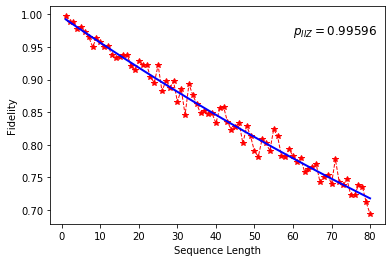

In [439]:
y_IIZ_ref = [func(i, popt_IIZ_ref[0], popt_IIZ_ref[1], popt_IIZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IIZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.97, r'$p_{IIZ} =$' + str(0.99596), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IIZ.pdf')

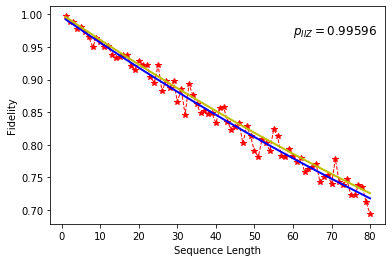

In [448]:
y_IIZ_ref = [func(i, popt_IIZ_ref[0], popt_IIZ_ref[1], popt_IIZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IIZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.97, r'$p_{IIZ} =$' + str(0.99596), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IIZ2.pdf')

2) $p_{IZI}$

In [401]:
prob_IZI_ref = weighted_prob(RB_ref_ZZZ, [0, 1, 0], [12])
twirling_IZI = twirling_ideal(seq_length_total, 12)
popt_IZI_ref, pcov_IZI_ref = curve_fit(func, range(1, seq_length_total + 1), prob_IZI_ref)
print('The fitting parameters for p, A, B are:', popt_IZI_ref)
print('The ideal twirling parameter is', twirling_IZI[0])

The fitting parameters for p, A, B are: [0.99671016 0.9259621  0.07188847]
The ideal twirling parameter is 0.9969999999999348


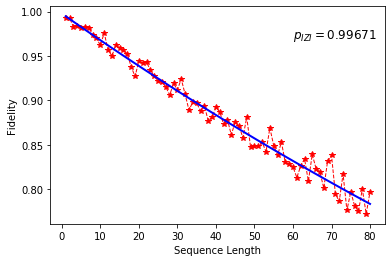

In [441]:
y_IZI_ref = [func(i, popt_IZI_ref[0], popt_IZI_ref[1], popt_IZI_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IZI_ref, color="b", linewidth=2.0)
plt.text(60, 0.97, r'$p_{IZI} =$' + str(0.99671), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZI.pdf')

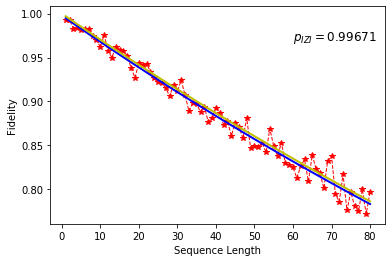

In [447]:
y_IZI_ref = [func(i, popt_IZI_ref[0], popt_IZI_ref[1], popt_IZI_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IZI_ref, color="b", linewidth=2.0)
plt.text(60, 0.97, r'$p_{IZI} =$' + str(0.99671), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZI2.pdf')

3) $p_{IZZ}$

In [452]:
prob_IZZ_ref = weighted_prob(RB_ref_ZZZ, [0, 1, 1], [15])
twirling_IZZ = twirling_ideal(seq_length_total, 15)
popt_IZZ_ref, pcov_IZZ_ref = curve_fit(func, range(1, seq_length_total + 1), prob_IZZ_ref)
print('The fitting parameters for p, A, B are:', popt_IZZ_ref)
print('The ideal twirling parameter is', twirling_IZZ[0])

The fitting parameters for p, A, B are: [ 0.99381769  1.10458674 -0.11284319]
The ideal twirling parameter is 0.9930119999999348


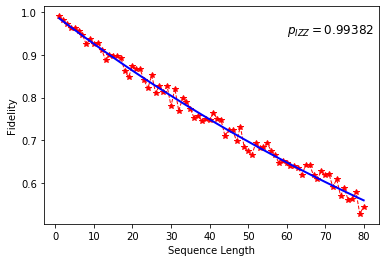

In [457]:
y_IZZ_ref = [func(i, popt_IZZ_ref[0], popt_IZZ_ref[1], popt_IZZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IZZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{IZZ} =$' + str(0.99382), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZZ.pdf')

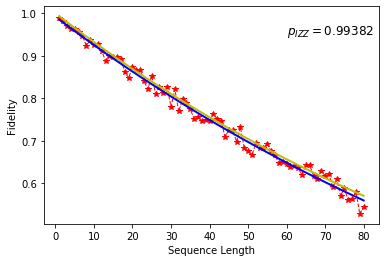

In [458]:
y_IZZ_ref = [func(i, popt_IZZ_ref[0], popt_IZZ_ref[1], popt_IZZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_IZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_IZZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{IZZ} =$' + str(0.99382), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZZ2.pdf')

4) $p_{ZII}, [48]$

In [460]:
prob_ZII_ref = weighted_prob(RB_ref_ZZZ, [1, 0, 0], [48])
twirling_ZII = twirling_ideal(seq_length_total, 48)
popt_ZII_ref, pcov_ZII_ref = curve_fit(func, range(1, seq_length_total + 1), prob_ZII_ref)
print('The fitting parameters for p, A, B are:', popt_ZII_ref)
print('The ideal twirling parameter is', twirling_ZII[0])

The fitting parameters for p, A, B are: [ 0.99955779  4.19218173 -3.19510538]
The ideal twirling parameter is 0.9980000000000404


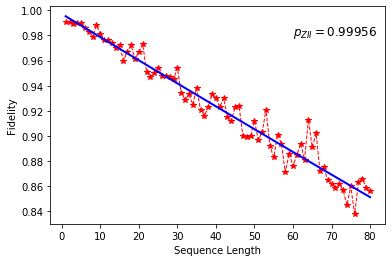

In [464]:
y_ZII_ref = [func(i, popt_ZII_ref[0], popt_ZII_ref[1], popt_ZII_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZII_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZII_ref, color="b", linewidth=2.0)
plt.text(60, 0.98, r'$p_{ZII} =$' + str(0.99956), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZII, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZII.pdf')

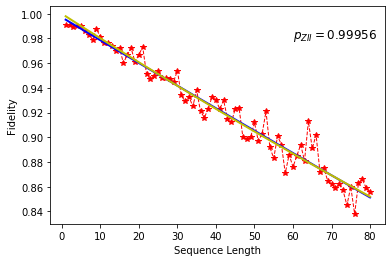

In [465]:
y_ZII_ref = [func(i, popt_ZII_ref[0], popt_ZII_ref[1], popt_ZII_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZII_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZII_ref, color="b", linewidth=2.0)
plt.text(60, 0.98, r'$p_{ZII} =$' + str(0.99956), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZII, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZII2.pdf')

5) $p_{ZIZ}, [51]$

In [471]:
prob_ZIZ_ref = weighted_prob(RB_ref_ZZZ, [1, 0, 1], [51])
twirling_ZIZ = twirling_ideal(seq_length_total, 51)
popt_ZIZ_ref, pcov_ZIZ_ref = curve_fit(func, range(1, seq_length_total + 1), prob_ZIZ_ref)
print('The fitting parameters for p, A, B are:', popt_ZIZ_ref)
print('The ideal twirling parameter is', twirling_ZIZ[0])

The fitting parameters for p, A, B are: [9.93964893e-01 9.93299892e-01 3.98972731e-04]
The ideal twirling parameter is 0.9940080000000355


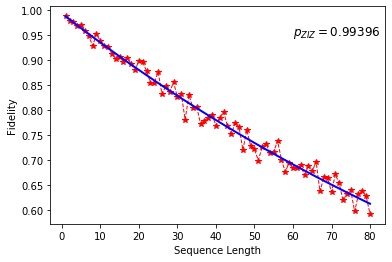

In [475]:
y_ZIZ_ref = [func(i, popt_ZIZ_ref[0], popt_ZIZ_ref[1], popt_ZIZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZIZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{ZIZ} =$' + str(0.99396), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZIZ.pdf')

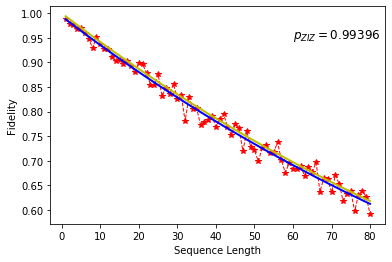

In [477]:
y_ZIZ_ref = [func(i, popt_ZIZ_ref[0], popt_ZIZ_ref[1], popt_ZIZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZIZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{ZIZ} =$' + str(0.99396), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZIZ2.pdf')

6) $p_{ZZI}, [60]$

In [479]:
prob_ZZI_ref = weighted_prob(RB_ref_ZZZ, [1, 1, 0], [60])
twirling_ZZI = twirling_ideal(seq_length_total, 60)
popt_ZZI_ref, pcov_ZZI_ref = curve_fit(func, range(1, seq_length_total + 1), prob_ZZI_ref)
print('The fitting parameters for p, A, B are:', popt_ZZI_ref)
print('The ideal twirling parameter is', twirling_ZZI[0])

The fitting parameters for p, A, B are: [ 0.99509789  1.00478828 -0.00969188]
The ideal twirling parameter is 0.9950060000000749


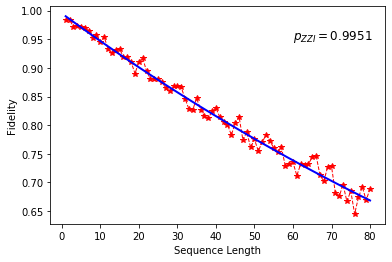

In [480]:
y_ZZI_ref = [func(i, popt_ZZI_ref[0], popt_ZZI_ref[1], popt_ZZI_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZZI_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{ZZI} =$' + str(0.99510), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZI.pdf')

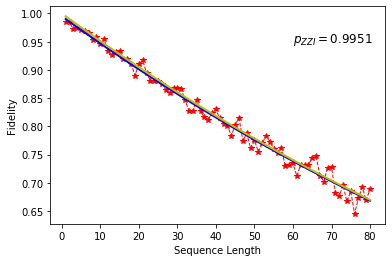

In [481]:
y_ZZI_ref = [func(i, popt_ZZI_ref[0], popt_ZZI_ref[1], popt_ZZI_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZZI_ref, color="b", linewidth=2.0)
plt.text(60, 0.95, r'$p_{ZZI} =$' + str(0.99510), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZI2.pdf')

7) $p_{ZZZ}, [63]$

In [482]:
prob_ZZZ_ref = weighted_prob(RB_ref_ZZZ, [1, 1, 1], [63])
twirling_ZZZ = twirling_ideal(seq_length_total, 63)
popt_ZZZ_ref, pcov_ZZZ_ref = curve_fit(func, range(1, seq_length_total + 1), prob_ZZZ_ref)
print('The fitting parameters for p, A, B are:', popt_ZZZ_ref)
print('The ideal twirling parameter is', twirling_ZZZ[0])

The fitting parameters for p, A, B are: [ 0.99109815  0.99432508 -0.0045738 ]
The ideal twirling parameter is 0.9910259759999533


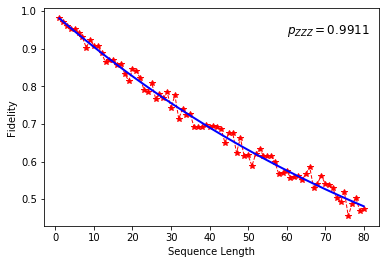

In [484]:
y_ZZZ_ref = [func(i, popt_ZZZ_ref[0], popt_ZZZ_ref[1], popt_ZZZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZZZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.94, r'$p_{ZZZ} =$' + str(0.99110), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZZ.pdf')

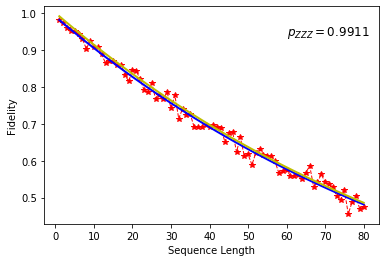

In [485]:
y_ZZZ_ref = [func(i, popt_ZZZ_ref[0], popt_ZZZ_ref[1], popt_ZZZ_ref[2]) for i in range(1, seq_length_total + 1)]
plt.plot(range(1, seq_length_total + 1), prob_ZZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1), y_ZZZ_ref, color="b", linewidth=2.0)
plt.text(60, 0.94, r'$p_{ZZZ} =$' + str(0.99110), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZZ2.pdf')

(2) we can calculate $p_{IIX}, p_{IZX}, p_{ZIX}, p_{ZZX}$ for the SPAM setting ($|{00+}\rangle, Z_1 \otimes Z_2 \otimes X_3$)

In [15]:
num_measure = 10000
seq_length_total = 88
rep_order_ZZX = [[1, 2], [13, 14], [49, 50], [61, 62]]

In [17]:
RB_ref_ZZX = RB_collect_measure_ref(num_measure, seq_length_total, 'ZZX')

In [18]:
RB_ref_ZZX = []
for i in range(0, seq_length_total, 3):
    RB_ref_ZZX.append(np.load('./ref/ref_ZZX' + str(i) + '.npy', allow_pickle = True))

1) $p_{IIX}, [1, 2]$

In [56]:
prob_IIX_ref = weighted_prob(RB_ref_ZZX, [0, 0, 1], [1, 2])
twirling_IIX = twirling_ideal(seq_length_total, 1)
popt_IIX_ref, pcov_IIX_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_IIX_ref, p0 = [twirling_IIX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_IIX_ref)
print('The ideal twirling parameter is', twirling_IIX[0])

The fitting parameters for p, A, B are: [0.99143869 0.60720488 0.39886234]
The ideal twirling parameter is 0.9955518336140647


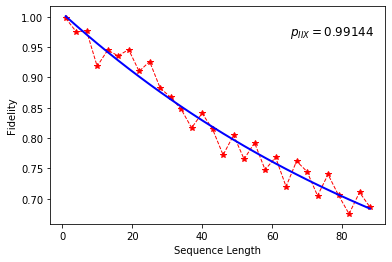

In [65]:
y_IIX_ref = [func(i, popt_IIX_ref[0], popt_IIX_ref[1], popt_IIX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_IIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_IIX_ref, color="b", linewidth=2.0)
plt.text(65, 0.97, r'$p_{IIX} =$' + str(0.99144), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IIX.pdf')

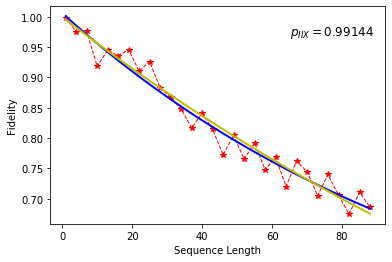

In [64]:
y_IIX_ref = [func(i, popt_IIX_ref[0], popt_IIX_ref[1], popt_IIX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_IIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_IIX_ref, color="b", linewidth=2.0)
plt.text(65, 0.97, r'$p_{IIX} =$' + str(0.99144), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IIX2.pdf')

2) $p_{IZX}, [13, 14]$

In [68]:
prob_IZX_ref = weighted_prob(RB_ref_ZZX, [0, 1, 1], [13, 14])
twirling_IZX = twirling_ideal(seq_length_total, 13)
popt_IZX_ref, pcov_IZX_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_IZX_ref, p0 = [twirling_IZX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_IZX_ref)
print('The ideal twirling parameter is', twirling_IZX[0])

The fitting parameters for p, A, B are: [0.98927839 0.75701413 0.24255791]
The ideal twirling parameter is 0.9925651781131763


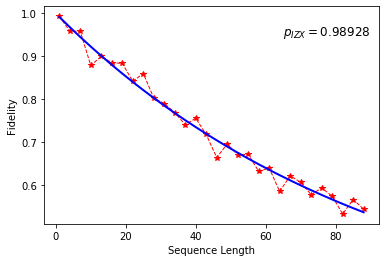

In [77]:
y_IZX_ref = [func(i, popt_IZX_ref[0], popt_IZX_ref[1], popt_IZX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_IZX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_IZX_ref, color="b", linewidth=2.0)
plt.text(65, 0.95, r'$p_{IZX} =$' + str(0.98928), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IZX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZX.pdf')

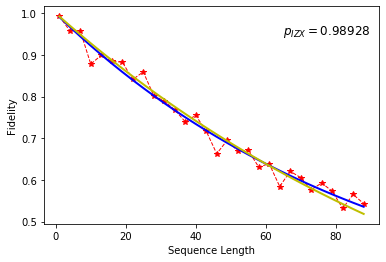

In [78]:
y_IZX_ref = [func(i, popt_IZX_ref[0], popt_IZX_ref[1], popt_IZX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_IZX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_IZX_ref, color="b", linewidth=2.0)
plt.text(65, 0.95, r'$p_{IZX} =$' + str(0.98928), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IZX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IZX2.pdf')

3) $p_{ZIX}, [49, 50]$

In [73]:
prob_ZIX_ref = weighted_prob(RB_ref_ZZX, [1, 0, 1], [49, 50])
twirling_ZIX = twirling_ideal(seq_length_total, 49)
popt_ZIX_ref, pcov_ZIX_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_ZIX_ref, p0 = [twirling_ZIX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_ZIX_ref)
print('The ideal twirling parameter is', twirling_ZIX[0])

The fitting parameters for p, A, B are: [0.99168828 0.83626545 0.16687913]
The ideal twirling parameter is 0.9935607299467156


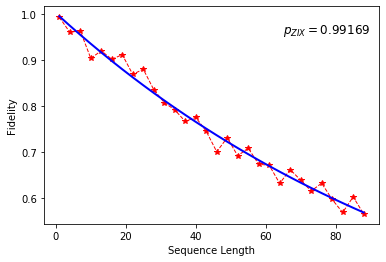

In [87]:
y_ZIX_ref = [func(i, popt_ZIX_ref[0], popt_ZIX_ref[1], popt_ZIX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_ZIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_ZIX_ref, color="b", linewidth=2.0)
plt.text(65, 0.96, r'$p_{ZIX} =$' + str(0.99169), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZIX.pdf')

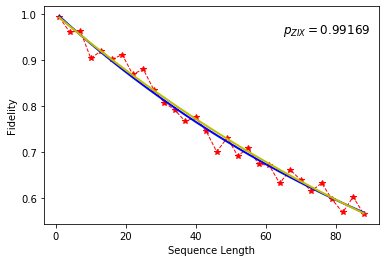

In [86]:
y_ZIX_ref = [func(i, popt_ZIX_ref[0], popt_ZIX_ref[1], popt_ZIX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_ZIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_ZIX_ref, color="b", linewidth=2.0)
plt.text(65, 0.96, r'$p_{ZIX} =$' + str(0.99169), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZIX2.pdf')

4) $p_{ZZX}, [61, 62]$

In [19]:
prob_ZZX_ref = weighted_prob(RB_ref_ZZX, [1, 1, 1], [61, 62])
twirling_ZZX = twirling_ideal(seq_length_total, 61)
popt_ZZX_ref, pcov_ZZX_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_ZZX_ref, p0 = [twirling_ZZX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_ZZX_ref)
print('The ideal twirling parameter is', twirling_ZZX[0])

The fitting parameters for p, A, B are: [0.98883286 0.88432392 0.1126171 ]
The ideal twirling parameter is 0.9905800477568801


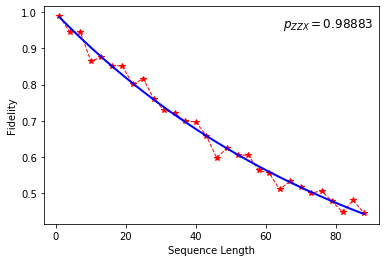

In [20]:
y_ZZX_ref = [func(i, popt_ZZX_ref[0], popt_ZZX_ref[1], popt_ZZX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_ZZX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_ZZX_ref, color="b", linewidth=2.0)
plt.text(65, 0.96, r'$p_{ZZX} =$' + str(0.98883), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZZX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZX.pdf')

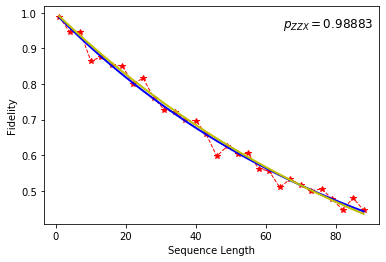

In [21]:
y_ZZX_ref = [func(i, popt_ZZX_ref[0], popt_ZZX_ref[1], popt_ZZX_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_ZZX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_ZZX_ref, color="b", linewidth=2.0)
plt.text(65, 0.96, r'$p_{ZZX} =$' + str(0.98883), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZZX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZZX2.pdf')

(3) we can calculate $p_{IXI}, p_{IXZ}, p_{ZXI}, p_{ZXZ}$ for the SPAM setting ($|{0+0}\rangle, Z_1 \otimes X_2 \otimes Z_3$)

In [15]:
num_measure = 10000
seq_length_total = 101
rep_order_ZZX = [[4, 8], [7, 11], [52, 56], [55, 59]]

In [17]:
RB_ref_ZXZ = RB_collect_measure_ref(num_measure, seq_length_total, 'ZXZ')

In [17]:
RB_ref_ZXZ = []
for i in range(0, seq_length_total, 4):
    RB_ref_ZXZ.append(np.load('./ref/ref_ZXZ' + str(i) + '.npy', allow_pickle = True))

1) $p_{IXI}, [4, 8]$

In [28]:
prob_IXI_ref = weighted_prob(RB_ref_ZXZ, [0, 1, 0], [4, 8])
twirling_IXI = twirling_ideal(seq_length_total, 4)
popt_IXI_ref, pcov_IXI_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_IXI_ref, p0 = [twirling_IXI[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_IXI_ref)
print('The ideal twirling parameter is', twirling_IXI[0])

The fitting parameters for p, A, B are: [ 0.99892016  2.6673259  -1.67342316]
The ideal twirling parameter is 0.996800606646525


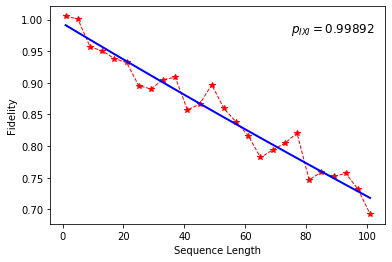

In [30]:
y_IXI_ref = [func(i, popt_IXI_ref[0], popt_IXI_ref[1], popt_IXI_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXI_ref, color="b", linewidth=2.0)
plt.text(75, 0.98, r'$p_{IXI} =$' + str(0.99892), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IXI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXI.pdf')

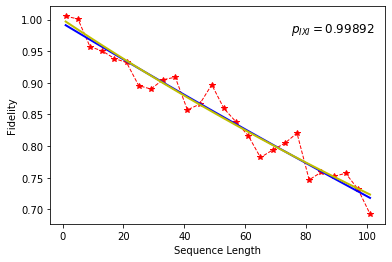

In [31]:
y_IXI_ref = [func(i, popt_IXI_ref[0], popt_IXI_ref[1], popt_IXI_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXI_ref, color="b", linewidth=2.0)
plt.text(75, 0.98, r'$p_{IXI} =$' + str(0.99892), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IXI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXI2.pdf')

2) $p_{IXZ}, [7, 11]$

In [32]:
prob_IXZ_ref = weighted_prob(RB_ref_ZXZ, [0, 1, 1], [7, 11])
twirling_IXZ = twirling_ideal(seq_length_total, 7)
popt_IXZ_ref, pcov_IXZ_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_IXZ_ref, p0 = [twirling_IXZ[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_IXZ_ref)
print('The ideal twirling parameter is', twirling_IXZ[0])

The fitting parameters for p, A, B are: [0.99241361 0.96788351 0.03089822]
The ideal twirling parameter is 0.9928134042201001


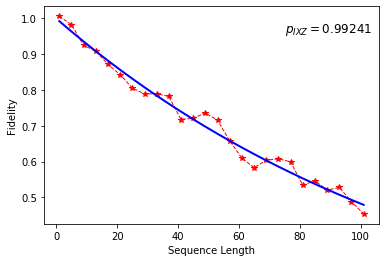

In [39]:
y_IXZ_ref = [func(i, popt_IXZ_ref[0], popt_IXZ_ref[1], popt_IXZ_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{IXZ} =$' + str(0.99241), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IXZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXZ.pdf')

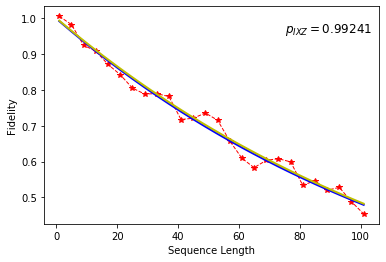

In [40]:
y_IXZ_ref = [func(i, popt_IXZ_ref[0], popt_IXZ_ref[1], popt_IXZ_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{IXZ} =$' + str(0.99241), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IXZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXZ2.pdf')

3) $p_{ZXI}, [52, 56]$

In [41]:
prob_ZXI_ref = weighted_prob(RB_ref_ZXZ, [1, 1, 0], [52, 56])
twirling_ZXI = twirling_ideal(seq_length_total, 52)
popt_ZXI_ref, pcov_ZXI_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_ZXI_ref, p0 = [twirling_ZXI[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_ZXI_ref)
print('The ideal twirling parameter is', twirling_ZXI[0])

The fitting parameters for p, A, B are: [ 0.99520975  1.06433844 -0.06864097]
The ideal twirling parameter is 0.9948070054333356


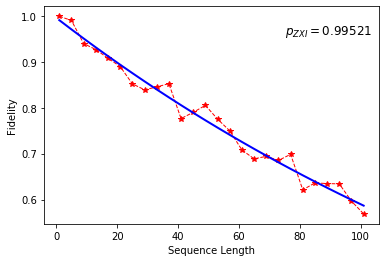

In [42]:
y_ZXI_ref = [func(i, popt_ZXI_ref[0], popt_ZXI_ref[1], popt_ZXI_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXI_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{ZXI} =$' + str(0.99521), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZXI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXI.pdf')

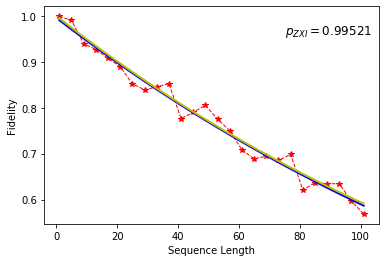

In [43]:
y_ZXI_ref = [func(i, popt_ZXI_ref[0], popt_ZXI_ref[1], popt_ZXI_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXI_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{ZXI} =$' + str(0.99521), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZXI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXI2.pdf')

4) $p_{ZXZ}, [55, 59]$

In [45]:
prob_ZXZ_ref = weighted_prob(RB_ref_ZXZ, [1, 1, 1], [55, 59])
twirling_ZXZ = twirling_ideal(seq_length_total, 55)
popt_ZXZ_ref, pcov_ZXZ_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_ZXZ_ref, p0 = [twirling_ZXZ[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_ZXZ_ref)
print('The ideal twirling parameter is', twirling_ZXZ[0])

The fitting parameters for p, A, B are: [0.99009717 0.95898416 0.04063591]
The ideal twirling parameter is 0.9908277774115891


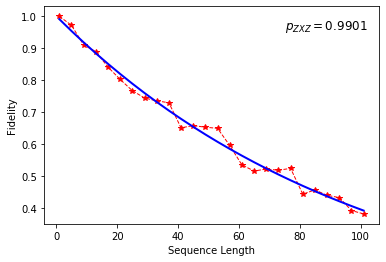

In [46]:
y_ZXZ_ref = [func(i, popt_ZXZ_ref[0], popt_ZXZ_ref[1], popt_ZXZ_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{ZXZ} =$' + str(0.99010), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZXZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXZ.pdf')

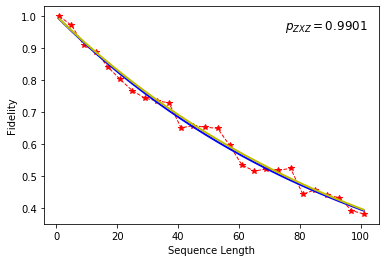

In [47]:
y_ZXZ_ref = [func(i, popt_ZXZ_ref[0], popt_ZXZ_ref[1], popt_ZXZ_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.96, r'$p_{ZXZ} =$' + str(0.99010), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZXZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXZ2.pdf')

(4) we can calculate $p_{IXX}, p_{ZXX}$ for the SPAM setting ($|{0+0}\rangle, Z_1 \otimes X_2 \otimes X_3$)

In [16]:
num_measure = 10000
seq_length_total = 101
rep_order_ZXX = [[5, 6, 9, 10], [53, 54, 57, 58]]

1) $p_{IXX}, [5, 6, 9, 10]$

In [20]:
RB_ref_IXX = RB_sample_measure_ref(num_measure, seq_length_total, 'IXX')

In [17]:
RB_ref_IXX = []
for i in range(0, seq_length_total, 4):
    RB_ref_IXX.append(np.load('./ref/ref_IXX' + str(i) + '.npy', allow_pickle = True))

In [20]:
prob_IXX_ref = weighted_prob2(RB_ref_IXX, [5, 6, 9, 10])
twirling_IXX = twirling_ideal(seq_length_total, 6)
popt_IXX_ref, pcov_IXX_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_IXX_ref, p0 = [twirling_IXX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_IXX_ref)
print('The ideal twirling parameter is', twirling_IXX[0])

The fitting parameters for p, A, B are: [ 0.99547799  1.36013805 -0.40250161]
The ideal twirling parameter is 0.9923666716945267


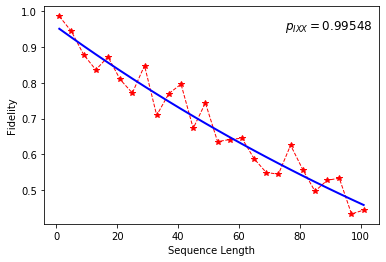

In [23]:
y_IXX_ref = [func(i, popt_IXX_ref[0], popt_IXX_ref[1], popt_IXX_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXX_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{IXX} =$' + str(0.99548), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_IXX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXX.pdf')

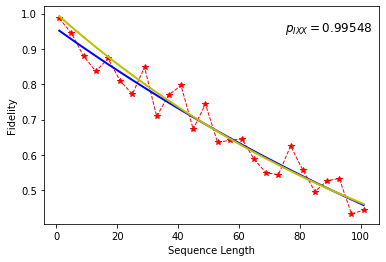

In [24]:
y_IXX_ref = [func(i, popt_IXX_ref[0], popt_IXX_ref[1], popt_IXX_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_IXX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_IXX_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{IXX} =$' + str(0.99548), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_IXX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_IXX2.pdf')

2) $p_{ZXX}, [53, 54, 57, 58]$

In [18]:
RB_ref_ZXX = RB_sample_measure_ref(num_measure, seq_length_total, 'ZXX', [53, 54, 57, 58])

In [22]:
prob_ZXX_ref = weighted_prob2(RB_ref_ZXX)
twirling_ZXX = twirling_ideal(seq_length_total, 53)
popt_ZXX_ref, pcov_ZXX_ref = curve_fit(func, range(1, seq_length_total + 1, 4), prob_ZXX_ref, p0 = [twirling_ZXX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_ZXX_ref)
print('The ideal twirling parameter is', twirling_ZXX[0])

The fitting parameters for p, A, B are: [0.98964269 0.99625799 0.00321124]
The ideal twirling parameter is 0.9903819383511971


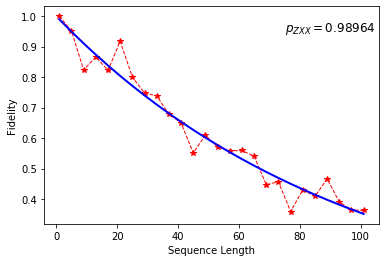

In [23]:
y_ZXX_ref = [func(i, popt_ZXX_ref[0], popt_ZXX_ref[1], popt_ZXX_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXX_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{ZXX} =$' + str(0.98964), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_ZXX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXX.pdf')

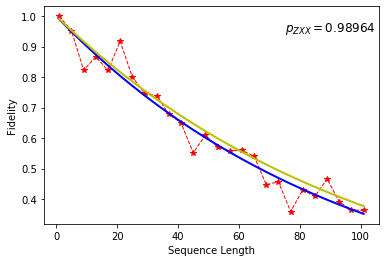

In [24]:
y_ZXX_ref = [func(i, popt_ZXX_ref[0], popt_ZXX_ref[1], popt_ZXX_ref[2]) for i in range(1, seq_length_total + 1, 4)]
plt.plot(range(1, seq_length_total + 1, 4), prob_ZXX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 4), y_ZXX_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{ZXX} =$' + str(0.98964), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_ZXX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_ZXX2.pdf')

(5) we can calculate $p_{XII}, p_{XIZ}, p_{XZI}, p_{XZZ}$ for the SPAM setting ($|{+00}\rangle, X_1 \otimes Z_2 \otimes Z_3$)

In [23]:
rep_order_ZXX = [[16, 32], [19, 35], [28, 44], [31, 47]]

1) $p_{XII}, [16, 32]$

In [55]:
num_measure = 10000
seq_length_total = 150
interval = 4
RB_ref_XII = RB_sample_measure_ref(num_measure, seq_length_total, 'XII', [16, 32], interval)

In [56]:
prob_XII_ref = weighted_prob2(RB_ref_XII)
twirling_XII = twirling_ideal(seq_length_total, 16)
popt_XII_ref, pcov_XII_ref = curve_fit(func, range(1, seq_length_total + 1, interval), prob_XII_ref, p0 = [twirling_XII[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_XII_ref)
print('The ideal twirling parameter is', twirling_XII[0])

The fitting parameters for p, A, B are: [0.99718043 0.77883877 0.22830365]
The ideal twirling parameter is 0.9979501004158704


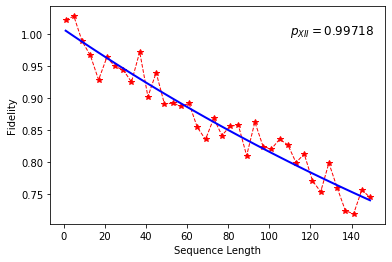

In [69]:
y_XII_ref = [func(i, popt_XII_ref[0], popt_XII_ref[1], popt_XII_ref[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob_XII_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y_XII_ref, color="b", linewidth=2.0)
plt.text(110, 1, r'$p_{XII} =$' + str(0.99718), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_XII, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XII.pdf')

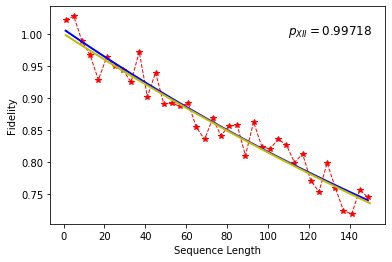

In [68]:
y_XII_ref = [func(i, popt_XII_ref[0], popt_XII_ref[1], popt_XII_ref[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob_XII_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y_XII_ref, color="b", linewidth=2.0)
plt.text(110, 1, r'$p_{XII} =$' + str(0.99718), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_XII, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XII2.pdf')

2) $p_{XIZ}, [19, 35]$

In [32]:
num_measure = 10000
seq_length_total = 100
RB_ref_XIZ = RB_sample_measure_ref(num_measure, seq_length_total, 'XIZ', [19, 35])

In [33]:
prob_XIZ_ref = weighted_prob2(RB_ref_XIZ)
twirling_XIZ = twirling_ideal(seq_length_total, 19)
popt_XIZ_ref, pcov_XIZ_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_XIZ_ref, p0 = [twirling_XIZ[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_XIZ_ref)
print('The ideal twirling parameter is', twirling_XIZ[0])

The fitting parameters for p, A, B are: [ 0.99398074  1.03001614 -0.02564686]
The ideal twirling parameter is 0.9939583000141341


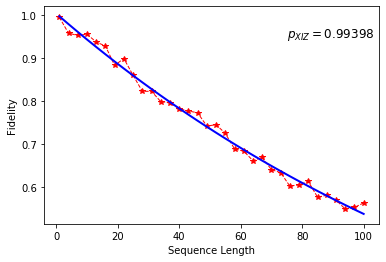

In [34]:
y_XIZ_ref = [func(i, popt_XIZ_ref[0], popt_XIZ_ref[1], popt_XIZ_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XIZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{XIZ} =$' + str(0.99398), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_XIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XIZ.pdf')

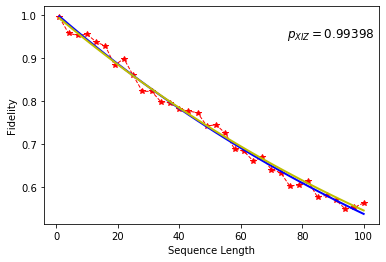

In [35]:
y_XIZ_ref = [func(i, popt_XIZ_ref[0], popt_XIZ_ref[1], popt_XIZ_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XIZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XIZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{XIZ} =$' + str(0.99398), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_XIZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XIZ2.pdf')

3) $p_{XZI}, [28, 44]$

In [36]:
num_measure = 10000
seq_length_total = 100
RB_ref_XZI = RB_sample_measure_ref(num_measure, seq_length_total, 'XZI', [28, 44])

In [43]:
prob_XZI_ref = weighted_prob2(RB_ref_XZI)
twirling_XZI = twirling_ideal(seq_length_total, 28)
popt_XZI_ref, pcov_XZI_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_XZI_ref, p0 = [twirling_XZI[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_XZI_ref)
print('The ideal twirling parameter is', twirling_XZI[0])

The fitting parameters for p, A, B are: [0.9931096  0.78728238 0.21094774]
The ideal twirling parameter is 0.9949562501146547


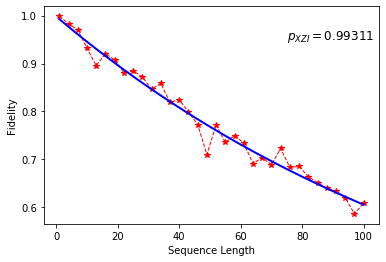

In [44]:
y_XZI_ref = [func(i, popt_XZI_ref[0], popt_XZI_ref[1], popt_XZI_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XZI_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{XZI} =$' + str(0.99311), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_XZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZI.pdf')

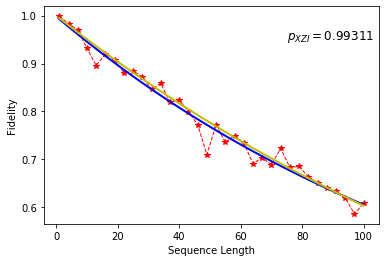

In [45]:
y_XZI_ref = [func(i, popt_XZI_ref[0], popt_XZI_ref[1], popt_XZI_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XZI_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XZI_ref, color="b", linewidth=2.0)
plt.text(75, 0.95, r'$p_{XZI} =$' + str(0.99311), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_XZI, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZI2.pdf')

4) $p_{XZZ}, [31, 47]$

In [46]:
num_measure = 10000
seq_length_total = 100
RB_ref_XZZ = RB_sample_measure_ref(num_measure, seq_length_total, 'XZZ', [31, 47])

In [47]:
prob_XZZ_ref = weighted_prob2(RB_ref_XZZ)
twirling_XZZ = twirling_ideal(seq_length_total, 31)
popt_XZZ_ref, pcov_XZZ_ref = curve_fit(func, range(1, seq_length_total + 1, 3), prob_XZZ_ref, p0 = [twirling_XZZ[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_XZZ_ref)
print('The ideal twirling parameter is', twirling_XZZ[0])

The fitting parameters for p, A, B are: [0.9904615  0.95739163 0.03554381]
The ideal twirling parameter is 0.9909764251141545


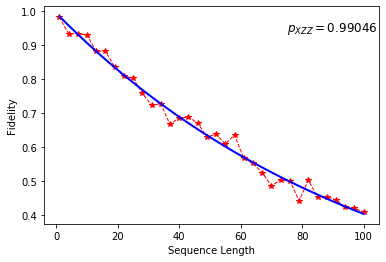

In [50]:
y_XZZ_ref = [func(i, popt_XZZ_ref[0], popt_XZZ_ref[1], popt_XZZ_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XZZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.94, r'$p_{XZZ} =$' + str(0.99046), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_XZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZZ.pdf')

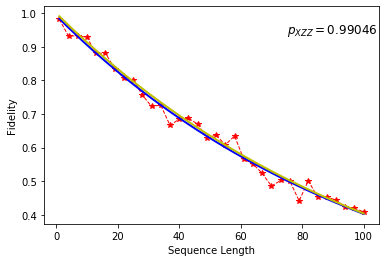

In [51]:
y_XZZ_ref = [func(i, popt_XZZ_ref[0], popt_XZZ_ref[1], popt_XZZ_ref[2]) for i in range(1, seq_length_total + 1, 3)]
plt.plot(range(1, seq_length_total + 1, 3), prob_XZZ_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, 3), y_XZZ_ref, color="b", linewidth=2.0)
plt.text(75, 0.94, r'$p_{XZZ} =$' + str(0.99046), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_XZZ, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZZ2.pdf')

(6) we can calculate $p_{XIX}, p_{XZX}$ for the SPAM setting ($|{+0+}\rangle, X_1 \otimes Z_2 \otimes X_3$)

In [77]:
rep_order_XZX = [[17, 18, 33, 34], [29, 30, 45, 46]]

1) $p_{XIX}, [17, 18, 33, 34]$

In [18]:
num_measure = 10000
seq_length_total = 100
interval = 3
RB_ref_XIX = RB_sample_measure_ref(num_measure, seq_length_total, 'XIX', [17, 18, 33, 34], interval)

In [22]:
prob_XIX_ref = weighted_prob2(RB_ref_XIX)
twirling_XIX = twirling_ideal(seq_length_total, 17)
popt_XIX_ref, pcov_XIX_ref = curve_fit(func, range(1, seq_length_total + 1, interval), prob_XIX_ref, p0 = [twirling_XIX[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt_XIX_ref)
print('The ideal twirling parameter is', twirling_XIX[0])

The fitting parameters for p, A, B are: [ 0.99912999  5.29101584 -4.33391008]
The ideal twirling parameter is 0.9935110523242642


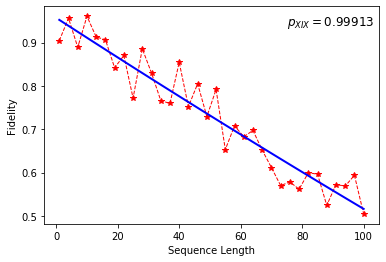

In [23]:
y_XIX_ref = [func(i, popt_XIX_ref[0], popt_XIX_ref[1], popt_XIX_ref[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob_XIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y_XIX_ref, color="b", linewidth=2.0)
plt.text(75, 0.94, r'$p_{XIX} =$' + str(0.99913), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirling_XIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XIX.pdf')

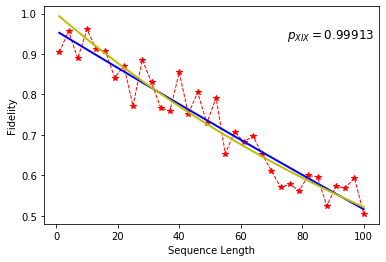

In [25]:
y_XIX_ref = [func(i, popt_XIX_ref[0], popt_XIX_ref[1], popt_XIX_ref[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob_XIX_ref, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y_XIX_ref, color="b", linewidth=2.0)
plt.text(75, 0.94, r'$p_{XIX} =$' + str(0.99913), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirling_XIX, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XIX2.pdf')

2) $p_{XZX}, [29, 30, 45, 46]$

In [27]:
num_measure = 10000
seq_length_total = 100
interval = 3
RB_ref_XZX = RB_sample_measure_ref(num_measure, seq_length_total, 'XZX', [29, 30, 45, 46], interval)

In [42]:
prob = weighted_prob2(RB_ref_XZX)
twirl = twirling_ideal(seq_length_total, 29)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter is', twirl[0])

The fitting parameters for p, A, B are: [ 0.99336     1.31976073 -0.32765947]
The ideal twirling parameter is 0.9905305191673276


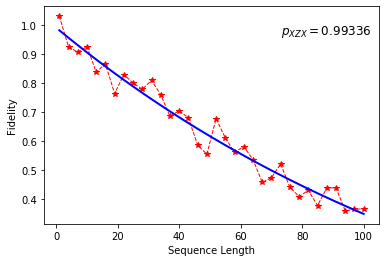

In [49]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(73, 0.97, r'$p_{XZX} =$' + str(0.99336), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZX.pdf')

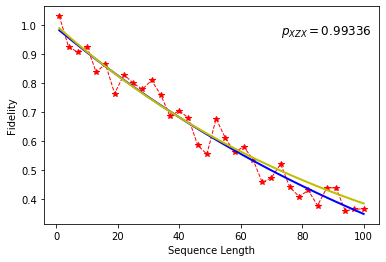

In [50]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(73, 0.97, r'$p_{XZX} =$' + str(0.99336), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XZX2.pdf')

(7) we can calculate $p_{XXI}, p_{XXZ}$ for the SPAM setting ($|{++0}\rangle, X_1 \otimes X_2 \otimes Z_3$)

In [55]:
rep_order_XXZ = [[20, 24, 36, 40], [23, 27, 39, 43]]

1) $p_{XXI}, [20, 24, 36, 40]$

In [70]:
num_measure = 10000
seq_length_total = 150
interval = 4
RB_ref_XXI = RB_sample_measure_ref(num_measure, seq_length_total, 'XXI', [20, 24, 36, 40], interval)

In [71]:
prob = weighted_prob2(RB_ref_XXI)
twirl = twirling_ideal(seq_length_total, 20)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter is', twirl[0])

The fitting parameters for p, A, B are: [0.99476267 0.98399103 0.01494289]
The ideal twirling parameter is 0.9947572654974479


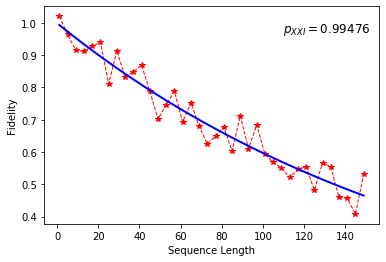

In [75]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(110, 0.97, r'$p_{XXI} =$' + str(0.99476), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXI.pdf')

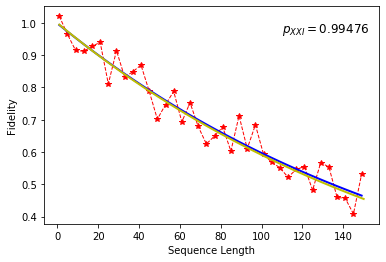

In [76]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(110, 0.97, r'$p_{XXI} =$' + str(0.99476), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXI2.pdf')

2) $p_{XXZ}, [23, 27, 39, 43]$

In [77]:
num_measure = 10000
seq_length_total = 100
interval = 3
RB_ref_XXZ = RB_sample_measure_ref(num_measure, seq_length_total, 'XXZ', [23, 27, 39, 43], interval)

In [85]:
prob = weighted_prob2(RB_ref_XXZ)
twirl = twirling_ideal(seq_length_total, 23)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter is', twirl[0])

The fitting parameters for p, A, B are: [0.99087345 0.96620948 0.01856891]
The ideal twirling parameter is 0.9907782364356298


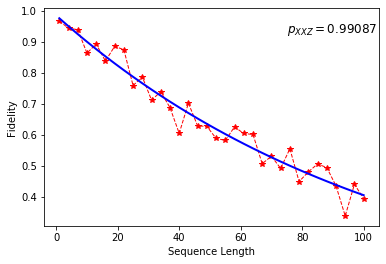

In [86]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(75, 0.93, r'$p_{XXZ} =$' + str(0.99087), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXZ.pdf')

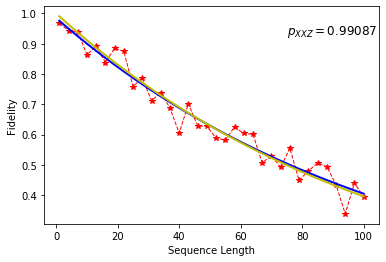

In [87]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(75, 0.93, r'$p_{XXZ} =$' + str(0.99087), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXZ2.pdf')

(8) we can calculate $p_{XXX}$ for the SPAM setting ($|{+++}\rangle, X_1 \otimes X_2 \otimes X_3$)

In [95]:
rep_order_XXX = [[21, 22, 25, 26, 37, 38, 41, 42]]

In [105]:
num_measure = 10000
seq_length_total = 100
interval = 3
RB_ref_XXX = RB_sample_measure_ref(num_measure, seq_length_total, 'XXX', [21, 22, 25, 26, 37, 38, 41, 42], interval)

In [112]:
prob = weighted_prob2(RB_ref_XXX)
twirl = twirling_ideal(seq_length_total, 22)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter is', twirl[0])

The fitting parameters for p, A, B are: [0.99068738 0.87913841 0.0494366 ]
The ideal twirling parameter is 0.9903324196669745


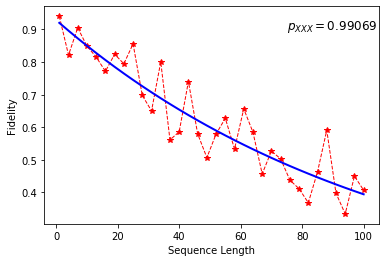

In [113]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(75, 0.9, r'$p_{XXX} =$' + str(0.99069), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXX.pdf')

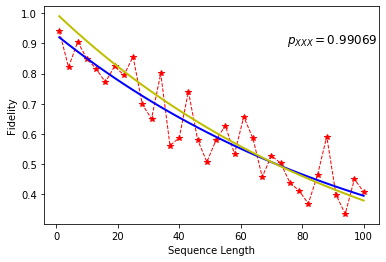

In [114]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(75, 0.9, r'$p_{XXX} =$' + str(0.99069), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./ref/ref_XXX2.pdf')

#### Conclusion: average reference process fidelity

In [129]:
p_ref = 1 + (0.99596 + 0.99671 + 0.99382 + 0.99956 + 0.99396 + 0.9951 + 0.9911) + 2 * (0.99144 + 0.98928 + 0.99169 + 0.98883) + 2 * (0.99892 + 0.99241 + 0.99521 + 0.9901) + 4 * (0.99548 + 0.98964) + 2 * (0.99718 + 0.99398 + 0.99311 + 0.99046) + 4 * (0.99913 + 0.99336) + 4 * (0.99476 + 0.99087) + 8 * 0.99069
p_ref / 64

0.99327984375

### Interleaved fidelity

(1) we can calculate $p_{IIZ}, p_{IZI}, p_{IZZ}, p_{ZII}, p_{ZIZ}, p_{ZZI}, p_{ZZZ}$ for the SPAM setting ($|{000}\rangle, Z_1 \otimes Z_2 \otimes Z_3$)

In [93]:
num_measure = 3000
seq_length_total = 20
interval = 1
rep_order_ZZZ = [[3], [12], [15], [48], [51], [60], [63]]

1) $p_{IIZ}, [3]$

In [91]:
RB_int_IIZ = RB_sample_measure_int(num_measure, seq_length_total, 'IIZ', [3], interval)

In [94]:
prob = weighted_prob2(RB_int_IIZ)
twirl = twirling_ideal_composite(seq_length_total, 3)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for CCZ gate is', twirl[0])

The fitting parameters for p, A, B are: [0.88978845 0.99511105 0.02005588]
The ideal twirling parameter for CCZ gate is 0.8964550083888095


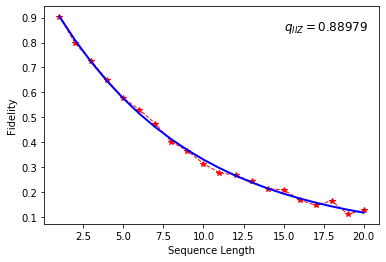

In [95]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{IIZ} =$' + str(0.88979), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IIZ.pdf')

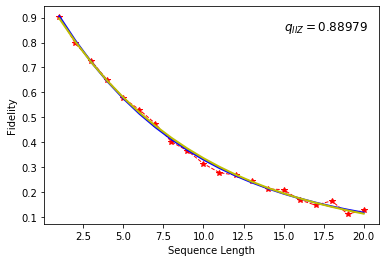

In [96]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{IIZ} =$' + str(0.88979), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IIZ2.pdf')

2) $p_{IZI}, [12]$

In [17]:
RB_int_IZI = RB_sample_measure_int(num_measure, seq_length_total, 'IZI', [12], interval)

In [98]:
prob = weighted_prob2(RB_int_IZI)
twirl = twirling_ideal_composite(seq_length_total, 12)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.89423349  1.02388132 -0.0029606 ]
The ideal twirling parameter for the composite channel is 0.8954534627501132


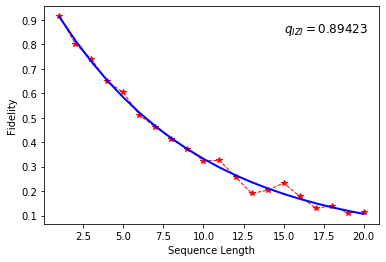

In [99]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{IZI} =$' + str(0.89423), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZI.pdf')

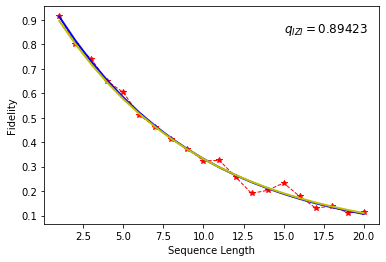

In [100]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{IZI} =$' + str(0.89423), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZI2.pdf')

3) $p_{IZZ}, [15]$

In [23]:
RB_int_IZZ = RB_sample_measure_int(num_measure, seq_length_total, 'IZZ', [15], interval)

In [102]:
prob = weighted_prob2(RB_int_IZZ)
twirl = twirling_ideal_composite(seq_length_total, 15)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.88363759 0.97913565 0.02351207]
The ideal twirling parameter for the composite channel is 0.8879327494446126


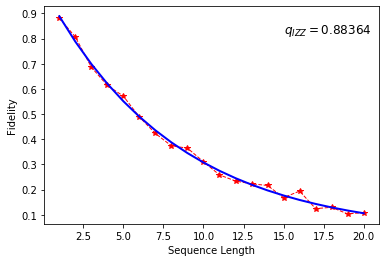

In [103]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{IZZ} =$' + str(0.88364), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZZ.pdf')

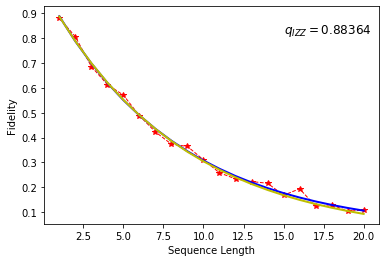

In [104]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{IZZ} =$' + str(0.88364), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZZ2.pdf')

4) $p_{ZII}, [48]$

In [32]:
RB_int_ZII = RB_sample_measure_int(num_measure, seq_length_total, 'ZII', [48], interval)

In [106]:
prob = weighted_prob2(RB_int_ZII)
twirl = twirling_ideal_composite(seq_length_total, 48)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.88628028 0.98039381 0.02732338]
The ideal twirling parameter for the composite channel is 0.8923929257106102


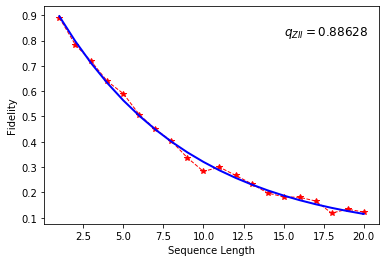

In [107]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZII} =$' + str(0.88628), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZII.pdf')

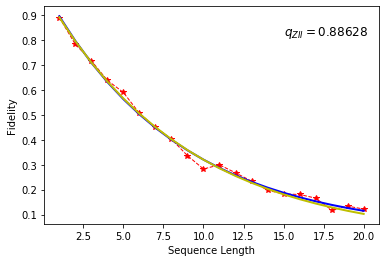

In [108]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZII} =$' + str(0.88628), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZII2.pdf')

5) $p_{ZIZ}, [51]$

In [37]:
RB_int_ZIZ = RB_sample_measure_int(num_measure, seq_length_total, 'ZIZ', [51], interval)

In [110]:
prob = weighted_prob2(RB_int_ZIZ)
twirl = twirling_ideal_composite(seq_length_total, 51)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.89614833  0.9882352  -0.00321984]
The ideal twirling parameter for the composite channel is 0.8927662042141129


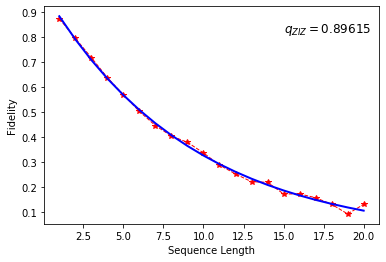

In [111]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZIZ} =$' + str(0.89615), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZIZ.pdf')

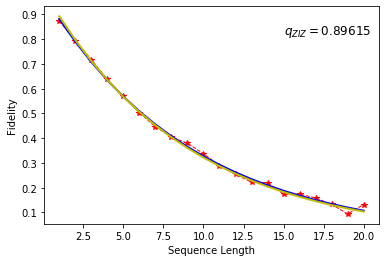

In [112]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZIZ} =$' + str(0.89615), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZIZ2.pdf')

6) $p_{ZZI}, [60]$

In [43]:
RB_int_ZZI = RB_sample_measure_int(num_measure, seq_length_total, 'ZZI', [60], interval)

In [114]:
prob = weighted_prob2(RB_int_ZZI)
twirl = twirling_ideal_composite(seq_length_total, 60)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.8866765  0.99842054 0.0195429 ]
The ideal twirling parameter for the composite channel is 0.8955603534909578


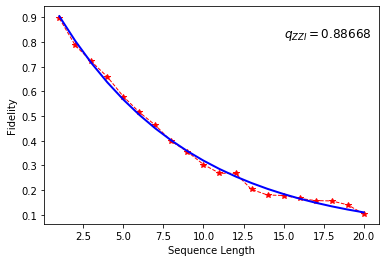

In [115]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZZI} =$' + str(0.88668), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZI.pdf')

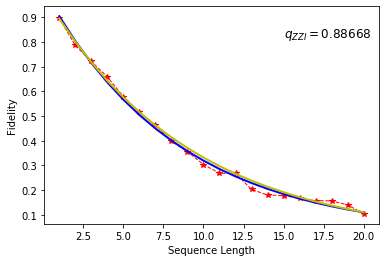

In [116]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{ZZI} =$' + str(0.88668), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZI2.pdf')

7) $p_{ZZZ}, [63]$

In [47]:
RB_int_ZZZ = RB_sample_measure_int(num_measure, seq_length_total, 'ZZZ', [63], interval)

In [118]:
prob = weighted_prob2(RB_int_ZZZ)
twirl = twirling_ideal_composite(seq_length_total, 63)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.90787349 0.98420273 0.02638003]
The ideal twirling parameter for the composite channel is 0.9144353499128886


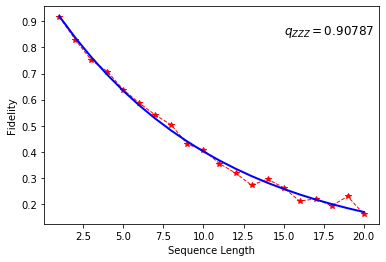

In [119]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{ZZZ} =$' + str(0.90787), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZZ.pdf')

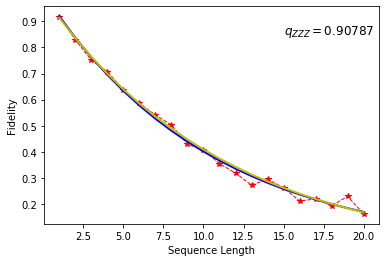

In [120]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.85, r'$q_{ZZZ} =$' + str(0.90787), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZZ2.pdf')

(2) we can calculate $p_{IIX}, p_{IZX}, p_{ZIX}, p_{ZZX}$ for the SPAM setting ($|{00+}\rangle, Z_1 \otimes Z_2 \otimes X_3$)

In [122]:
rep_order_ZZX = [[1, 2], [13, 14], [49, 50], [61, 62]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $p_{IIX}, [1, 2]$

In [73]:
RB_int_IIX = RB_sample_measure_int(num_measure, seq_length_total, 'IIX', [1, 2], interval)

In [123]:
prob = weighted_prob2(RB_int_IIX)
twirl = twirling_ideal_composite(seq_length_total, 1)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87720011  1.04609827 -0.05138827]
The ideal twirling parameter for the composite channel is 0.8752771287237094


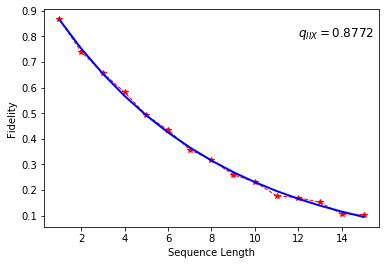

In [124]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(12, 0.8, r'$q_{IIX} =$' + str(0.87720), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IIX.pdf')

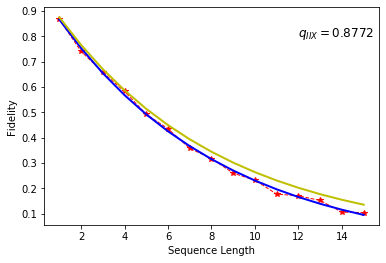

In [125]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(12, 0.8, r'$q_{IIX} =$' + str(0.87720), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IIX2.pdf')

2) $p_{IZX}, [13, 14]$

In [82]:
RB_int_IZX = RB_sample_measure_int(num_measure, seq_length_total, 'IZX', [13, 14], interval)

In [127]:
prob = weighted_prob2(RB_int_IZX)
twirl = twirling_ideal_composite(seq_length_total, 13)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.89043848  1.03643362 -0.08573364]
The ideal twirling parameter for the composite channel is 0.8577343532191557


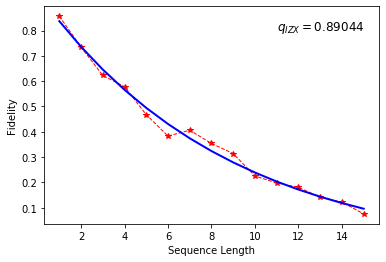

In [128]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IZX} =$' + str(0.89044), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZX.pdf')

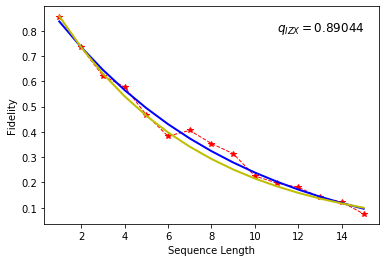

In [129]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IZX} =$' + str(0.89044), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IZX2.pdf')

3) $p_{ZIX}, [49, 50]$

In [130]:
RB_int_ZIX = RB_sample_measure_int(num_measure, seq_length_total, 'ZIX', [49, 50], interval)

In [131]:
prob = weighted_prob2(RB_int_ZIX)
twirl = twirling_ideal_composite(seq_length_total, 49)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.8716415   0.99000694 -0.00960367]
The ideal twirling parameter for the composite channel is 0.858594668518305


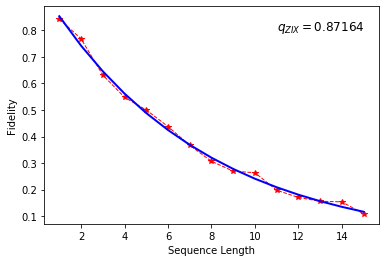

In [132]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZIX} =$' + str(0.87164), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZIX.pdf')

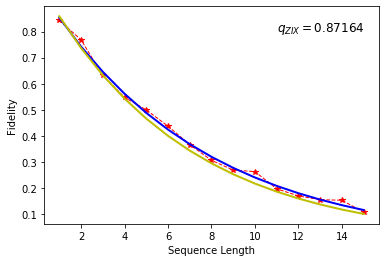

In [133]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZIX} =$' + str(0.87164), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZIX2.pdf')

4) $p_{ZZX}, [61, 62]$

In [134]:
RB_int_ZZX = RB_sample_measure_int(num_measure, seq_length_total, 'ZZX', [61, 62], interval)

In [135]:
prob = weighted_prob2(RB_int_ZZX)
twirl = twirling_ideal_composite(seq_length_total, 61)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87200955  1.01944753 -0.02379865]
The ideal twirling parameter for the composite channel is 0.8709059947428699


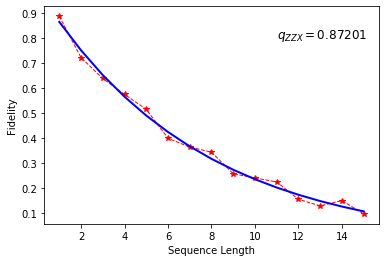

In [136]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZZX} =$' + str(0.87201), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZX.pdf')

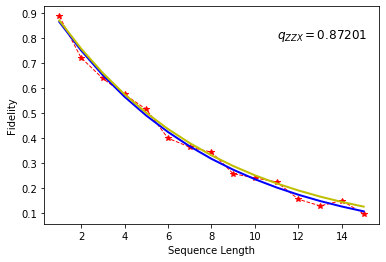

In [137]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZZX} =$' + str(0.87201), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZZX2.pdf')

(3) we can calculate $p_{IXI}, p_{IXZ}, p_{ZXI}, p_{ZXZ}$ for the SPAM setting ($|{0+0}\rangle, Z_1 \otimes X_2 \otimes Z_3$)

In [17]:
rep_order_ZZX = [[4, 8], [7, 11], [52, 56], [55, 59]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $p_{IXI}, [4, 8]$

In [23]:
RB_int_IXI = RB_sample_measure_int(num_measure, seq_length_total, 'IXI', [4, 8], interval)

In [24]:
prob = weighted_prob2(RB_int_IXI)
twirl = twirling_ideal_composite(seq_length_total, 4)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.86030342 0.99416978 0.01225593]
The ideal twirling parameter for the composite channel is 0.8730273345577433


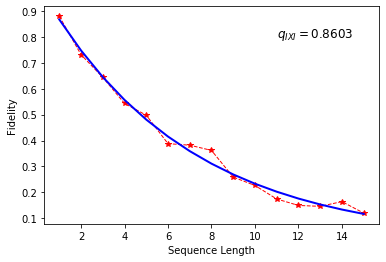

In [25]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXI} =$' + str(0.86030), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXI.pdf')

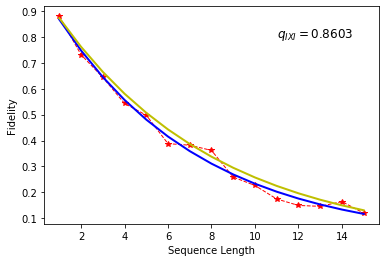

In [26]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXI} =$' + str(0.86030), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXI2.pdf')

2) $p_{IXZ}, [7, 11]$

In [27]:
RB_int_IXZ = RB_sample_measure_int(num_measure, seq_length_total, 'IXZ', [7, 11], interval)

In [28]:
prob = weighted_prob2(RB_int_IXZ)
twirl = twirling_ideal_composite(seq_length_total, 7)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.88322139  1.00625388 -0.05041325]
The ideal twirling parameter for the composite channel is 0.856536292303676


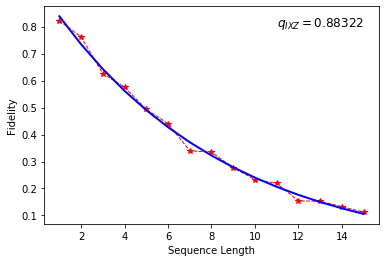

In [29]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXZ} =$' + str(0.88322), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXZ.pdf')

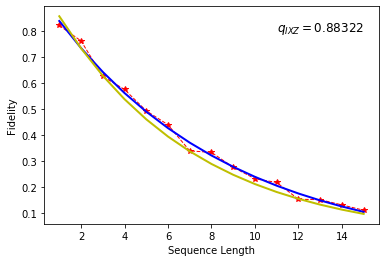

In [30]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXZ} =$' + str(0.88322), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXZ2.pdf')

3) $p_{ZXI}, [52, 56]$

In [31]:
RB_int_ZXI = RB_sample_measure_int(num_measure, seq_length_total, 'ZXI', [52, 56], interval)

In [32]:
prob = weighted_prob2(RB_int_ZXI)
twirl = twirling_ideal_composite(seq_length_total, 52)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.85187799 0.99301346 0.02978955]
The ideal twirling parameter for the composite channel is 0.8582562446978443


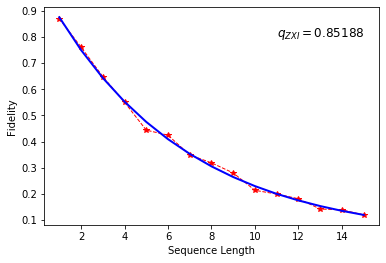

In [33]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZXI} =$' + str(0.85188), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXI.pdf')

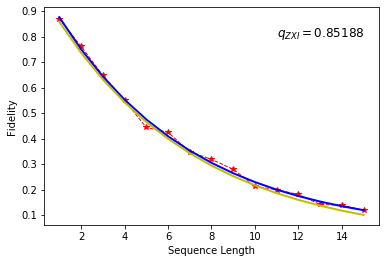

In [35]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZXI} =$' + str(0.85188), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXI2.pdf')

4) $p_{ZXZ}, [55, 59]$

In [36]:
RB_int_ZXZ = RB_sample_measure_int(num_measure, seq_length_total, 'ZXZ', [55, 59], interval)

In [37]:
prob = weighted_prob2(RB_int_ZXZ)
twirl = twirling_ideal_composite(seq_length_total, 55)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87447632  1.04222546 -0.03843635]
The ideal twirling parameter for the composite channel is 0.867796154769142


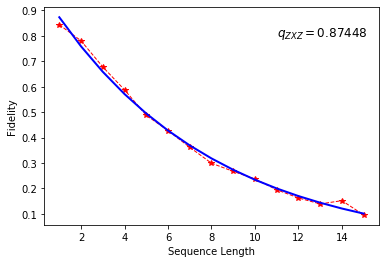

In [38]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZXZ} =$' + str(0.87448), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXZ.pdf')

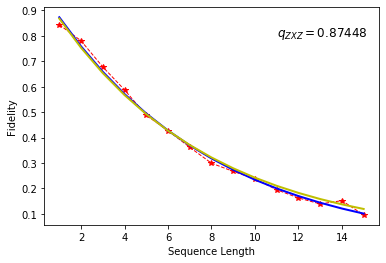

In [39]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{ZXZ} =$' + str(0.87448), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXZ2.pdf')

(4) we can calculate $q_{IXX}, q_{ZXX}$ for the SPAM setting ($|{0+0}\rangle, Z_1 \otimes X_2 \otimes X_3$)

In [53]:
rep_order_ZXX = [[5, 6, 9, 10], [53, 54, 57, 58]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $q_{IXX}, [5, 6, 9, 10]$

In [61]:
RB_int_IXX = RB_sample_measure_int(num_measure, seq_length_total, 'IXX', [5, 6, 9, 10], interval)

In [62]:
prob = weighted_prob2(RB_int_IXX)
twirl = twirling_ideal_composite(seq_length_total, 5)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87483627  0.98114998 -0.00383913]
The ideal twirling parameter for the composite channel is 0.8657711915712343


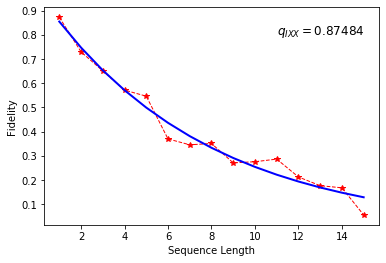

In [63]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXX} =$' + str(0.87484), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXX.pdf')

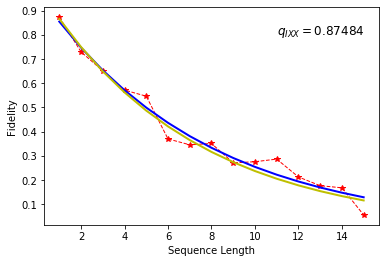

In [64]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{IXX} =$' + str(0.87484), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_IXX2.pdf')

2) $q_{ZXX}, [53, 54, 57, 58]$

In [65]:
RB_int_ZXX = RB_sample_measure_int(num_measure, seq_length_total, 'ZXX', [53, 54, 57, 58], interval)

In [66]:
prob = weighted_prob2(RB_int_ZXX)
twirl = twirling_ideal_composite(seq_length_total, 53)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.89290809  1.01790314 -0.09157674]
The ideal twirling parameter for the composite channel is 0.8640396491881737


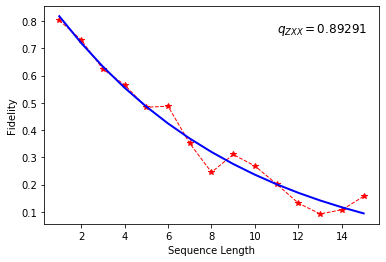

In [69]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.76, r'$q_{ZXX} =$' + str(0.89291), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXX.pdf')

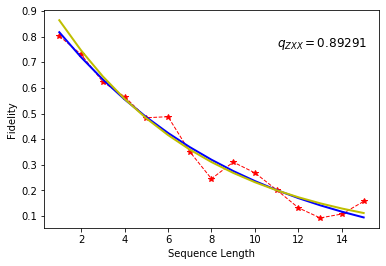

In [70]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.76, r'$q_{ZXX} =$' + str(0.89291), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_ZXX2.pdf')

(5) we can calculate $q_{XII}, q_{XIZ}, q_{XZI}, q_{XZZ}$ for the SPAM setting ($|{+00}\rangle, X_1 \otimes Z_2 \otimes Z_3$)

In [54]:
rep_order_ZXX = [[16, 32], [19, 35], [28, 44], [31, 47]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $q_{XII}, [16, 32]$

In [71]:
RB_int_XII = RB_sample_measure_int(num_measure, seq_length_total, 'XII', [16, 32], interval)

In [72]:
prob = weighted_prob2(RB_int_XII)
twirl = twirling_ideal_composite(seq_length_total, 16)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.83972526 0.98662107 0.05045778]
The ideal twirling parameter for the composite channel is 0.868323590931041


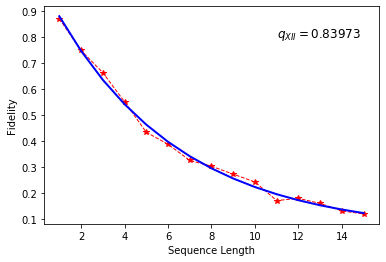

In [74]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XII} =$' + str(0.83973), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XII.pdf')

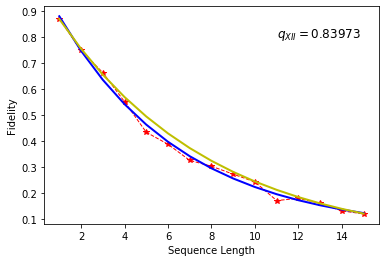

In [75]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XII} =$' + str(0.83973), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XII2.pdf')

2) $q_{XIZ}, [19, 35]$

In [76]:
RB_int_XIZ = RB_sample_measure_int(num_measure, seq_length_total, 'XIZ', [19, 35], interval)

In [77]:
prob = weighted_prob2(RB_int_XIZ)
twirl = twirling_ideal_composite(seq_length_total, 19)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.85269814 1.01104517 0.00242901]
The ideal twirling parameter for the composite channel is 0.8557369303871366


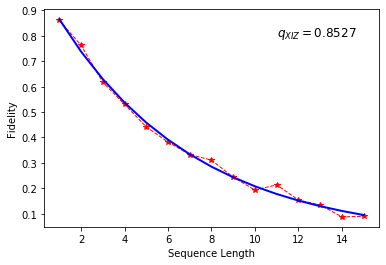

In [78]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XIZ} =$' + str(0.85270), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XIZ.pdf')

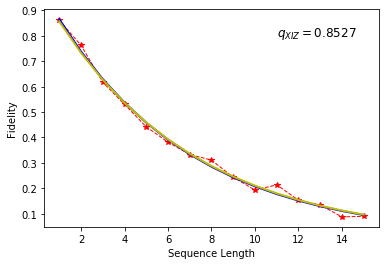

In [79]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XIZ} =$' + str(0.85270), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XIZ2.pdf')

3) $q_{XZI}, [28, 44]$

In [80]:
RB_int_XZI = RB_sample_measure_int(num_measure, seq_length_total, 'XZI', [28, 44], interval)

In [81]:
prob = weighted_prob2(RB_int_XZI)
twirl = twirling_ideal_composite(seq_length_total, 28)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.85339343 1.01100451 0.00606011]
The ideal twirling parameter for the composite channel is 0.8565961040120619


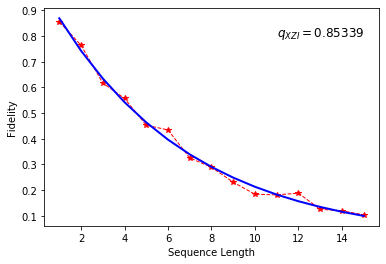

In [82]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XZI} =$' + str(0.85339), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZI.pdf')

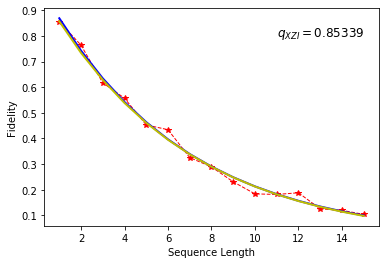

In [83]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XZI} =$' + str(0.85339), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZI2.pdf')

4) $q_{XZZ}, [31, 47]$

In [84]:
RB_int_XZZ = RB_sample_measure_int(num_measure, seq_length_total, 'XZZ', [31, 37], interval)

In [85]:
prob = weighted_prob2(RB_int_XZZ)
twirl = twirling_ideal_composite(seq_length_total, 31)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87504298  1.01778367 -0.03979685]
The ideal twirling parameter for the composite channel is 0.862255745677536


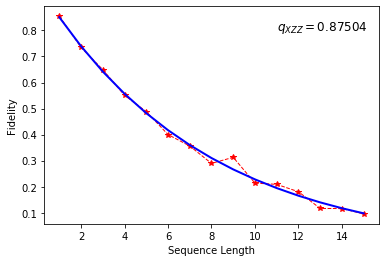

In [86]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XZZ} =$' + str(0.87504), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZZ.pdf')

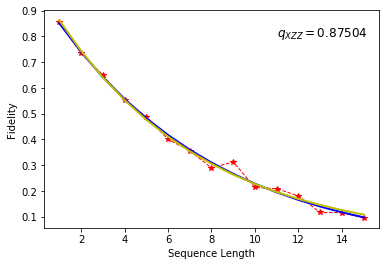

In [87]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.8, r'$q_{XZZ} =$' + str(0.87504), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZZ2.pdf')

(6) we can calculate $q_{XIX}, q_{XZX}$ for the SPAM setting ($|{+0+}\rangle, X_1 \otimes Z_2 \otimes X_3$)

In [26]:
rep_order_XZX = [[17, 18, 33, 34], [29, 30, 45, 46]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $q_{XIX}, [17, 18, 33, 34]$

In [24]:
RB_int_XIX = RB_sample_measure_int(num_measure, seq_length_total, 'XIX', [17, 18, 33, 34], interval)

In [27]:
prob = weighted_prob2(RB_int_XIX)
twirl = twirling_ideal_composite(seq_length_total, 17)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.86682045  1.08283495 -0.02383374]
The ideal twirling parameter for the composite channel is 0.870357295333828


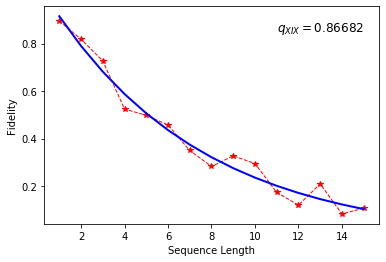

In [31]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XIX} =$' + str(0.86682), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XIX.pdf')

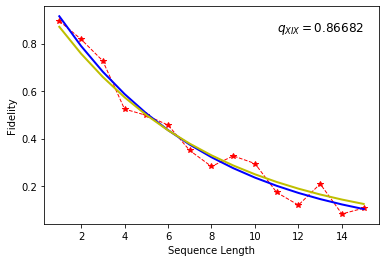

In [32]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XIX} =$' + str(0.86682), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XIX2.pdf')

2) $q_{XZX}, [29, 30, 45, 46]$

In [33]:
RB_int_XZX = RB_sample_measure_int(num_measure, seq_length_total, 'XZX', [29, 30, 45, 46], interval)

In [34]:
prob = weighted_prob2(RB_int_XZX)
twirl = twirling_ideal_composite(seq_length_total, 29)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.85561305 1.02667867 0.02431073]
The ideal twirling parameter for the composite channel is 0.8677462234477729


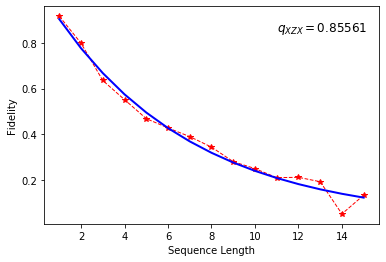

In [35]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XZX} =$' + str(0.85561), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZX.pdf')

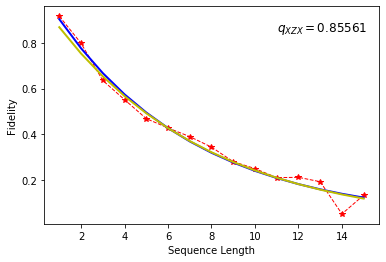

In [36]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XZX} =$' + str(0.85561), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XZX2.pdf')

(7) we can calculate $q_{XXI}, q_{XXZ}$ for the SPAM setting ($|{++0}\rangle, X_1 \otimes X_2 \otimes Z_3$)

In [108]:
rep_order_XXZ = [[20, 24, 36, 40], [23, 27, 39, 43]]
num_measure = 10000
seq_length_total = 15
interval = 1

1) $q_{XXI}, [20, 24, 36, 40]$

In [37]:
RB_int_XXI = RB_sample_measure_int(num_measure, seq_length_total, 'XXI', [20, 24, 36, 40], interval)

In [38]:
prob = weighted_prob2(RB_int_XXI)
twirl = twirling_ideal_composite(seq_length_total, 20)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.8432876  1.02297655 0.04751784]
The ideal twirling parameter for the composite channel is 0.8735311502973926


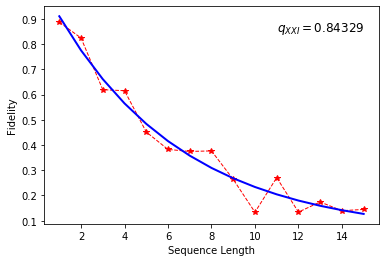

In [39]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XXI} =$' + str(0.84329), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXI.pdf')

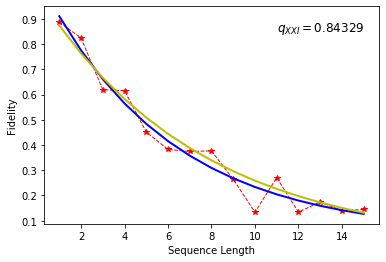

In [40]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.85, r'$q_{XXI} =$' + str(0.84329), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXI2.pdf')

2) $q_{XXZ}, [23, 27, 39, 43]$

In [41]:
RB_int_XXZ = RB_sample_measure_int(num_measure, seq_length_total, 'XXZ', [23, 27, 39, 43], interval)

In [42]:
prob = weighted_prob2(RB_int_XXZ)
twirl = twirling_ideal_composite(seq_length_total, 23)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [ 0.87667474  1.00332927 -0.01278691]
The ideal twirling parameter for the composite channel is 0.8700370256962083


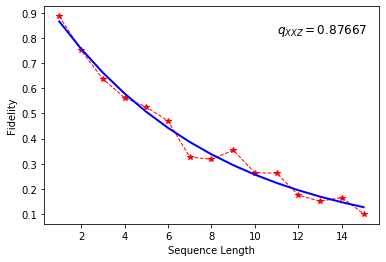

In [45]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.82, r'$q_{XXZ} =$' + str(0.87667), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXZ.pdf')

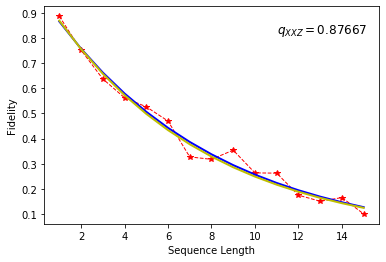

In [46]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(11, 0.82, r'$q_{XXZ} =$' + str(0.87667), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXZ2.pdf')

(8) we can calculate $q_{XXX}$ for the SPAM setting ($|{+++}\rangle, X_1 \otimes X_2 \otimes X_3$)

In [47]:
rep_order_XXX = [[21, 22, 25, 26, 37, 38, 41, 42]]
num_measure = 10000
seq_length_total = 20
interval = 1

In [48]:
RB_int_XXX = RB_sample_measure_int(num_measure, seq_length_total, 'XXX', [21, 22, 25, 26, 37, 38, 41, 42], interval)

In [49]:
prob = weighted_prob2(RB_int_XXX)
twirl = twirling_ideal_composite(seq_length_total, 21)
popt, pcov = curve_fit(func, range(1, seq_length_total + 1, interval), prob, p0 = [twirl[0], 1, 0])
print('The fitting parameters for p, A, B are:', popt)
print('The ideal twirling parameter for the composite channel is', twirl[0])

The fitting parameters for p, A, B are: [0.89284662 0.96444261 0.01619781]
The ideal twirling parameter for the composite channel is 0.8882894146218089


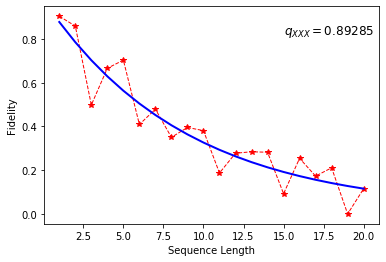

In [53]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{XXX} =$' + str(0.89285), fontsize = 12)
#plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXX.pdf')

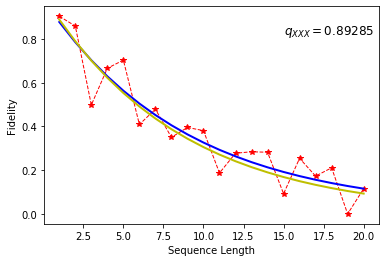

In [54]:
y = [func(i, popt[0], popt[1], popt[2]) for i in range(1, seq_length_total + 1, interval)]
plt.plot(range(1, seq_length_total + 1, interval), prob, color="r", linestyle="--", marker="*", linewidth=1.0)
plt.plot(range(1, seq_length_total + 1, interval), y, color="b", linewidth=2.0)
plt.text(15, 0.82, r'$q_{XXX} =$' + str(0.89285), fontsize = 12)
plt.plot(range(1, seq_length_total + 1), twirl, color="y", linewidth=2.0)
plt.xlabel("Sequence Length")
plt.ylabel("Fidelity")
plt.savefig('./int/int_XXX2.pdf')

#### Conclusion: average interleaved process fidelity

In [56]:
q_int = 1 + (0.88979 + 0.89423 + 0.88364 + 0.88628 + 0.89615 + 0.88668 + 0.90787) + 2 * (0.8772 + 0.89044 + 0.87164 + 0.87201) + 2 * (0.8603 + 0.88322 + 0.85188 + 0.87448) + 4 * (0.87484 + 0.89291) + 2 * (0.83973 + 0.8527 + 0.85339 + 0.87504) + 4 * (0.86682 + 0.85561) + 4 * (0.84329 + 0.87667) + 8 * 0.89285
q_int / 64

0.8755009375000001

In [64]:
process_fidelity(np.dot(int_gate_channel, SingleQubit_channel))

0.8740857836038242

In [68]:
0.989 ** 50

0.5751943081964125